# 1. Introduction

In this notebook, our group performed a network and a text analysis. 
#### Network analysis
We visualized the products and the orders as a network. The nodes of the network are the products and if two products are included in the same order, there are linked with an edge. To build it we utilized the olist_order_items_dataset which included 32951 different products and 98666 different orders. We managed to generate the network for all these products and orders but it was very time-consuming and quite complex. Instead, We chose to visualize only the network for the 1000 most popular products. We kept all the information for the whole dataset and plotted the degree distribution to find out how many products are included in the average order.
#### Text analysis
Throughout this part we will analyze the text from the reviews the customers have given to the purchased products.
In the first part we will do a topic analysis using LDA in order to investigate what are the main topics hidden in the reviews. We aim to get an understanding about customers' satisfaction as well as Olist customer service performance.

In the second part we will perform sentiment analysis on the reviews. The purpose of sentiment analysis is to predict the review score in cases that a customer has provided a comment but hasn't given a score. By predicting the review scores when they are missing will help Olist to get better understanding for products quality and overall service.

**Note**

The translated text for the reviews provided by a fellow student

In [64]:
# Import all necessary libraries

import pandas as pd
import matplotlib.pyplot as plt

# For network
import networkx as nx
from itertools import combinations,chain

# For text analysis
import re
import numpy as np
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from stopwords import get_stopwords
import string
from nltk.stem import WordNetLemmatizer
from PIL import Image
import wordcloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation

# For plotting layout
import seaborn as sns
import cycler

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\khade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\khade\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


The plotting style can be found here [cyberpunk-style-with-matplotlib](https://towardsdatascience.com/cyberpunk-style-with-matplotlib-f47404c9d4c5).

In [2]:
# Setting up plot layouts:

plt.style.use("seaborn-darkgrid")

for p1,p2,p3 in zip(['figure.facecolor', 'axes.facecolor', 'savefig.facecolor', 'savefig.facecolor'],['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color'],['font.size', 'xtick.labelsize', 'ytick.labelsize', 'ytick.labelsize']):
    plt.rcParams[p1], plt.rcParams[p2], plt.rcParams[p3] = '#212946', '0.95', '16'

plt.rcParams['figure.figsize']=(15, 15)
plt.rcParams['lines.linewidth'] = 3.0
plt.rcParams['legend.frameon'] = 'True'
plt.rcParams['legend.facecolor'] = '004466'
plt.rcParams['legend.edgecolor'] = '004466'
plt.rcParams['legend.framealpha'] = 0.8
plt.rcParams["image.cmap"] = "inferno"
plt.rcParams["axes.prop_cycle"] = cycler.cycler(color=[u'#00ff00',u'#ffff00',u'#00ffff',u'#ff00ff',u'#ffaa00',u'#ff0000',u'#0000ff',u'#00aa00',u'#aaaa00',u'#038273',u'#7d0ec2',u'#822d13',u'#720303',u'#000022'])


# 2. Product Network

To have an overview of the items and the orders they were included in, we decided to visualize them as a network. 
The graph aims to identify which items are connected the most. The nodes of the network will represent the products and the edges between them whether or not those two products were included in the same order. The graph will be simple, meaning that it will be undirected and with no self-loops.<br><br>
We will then analyze the networ with respect to it's connectivity and degree distribution. 

In [4]:
data=pd.read_csv(r"olist_order_items_dataset.csv")
data.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14


In [5]:
print("There are {} different products included in {} different orders.".format(len(data['product_id'].unique()),len(data['order_id'].unique())))

There are 32951 different products included in 98666 different orders.


## 2.1. Network Visualization
Since the volume of the data is somewhat large, displying a network of this size would be difficult. So for the visualization we will generate a network of the 1000 most popular products.
### 2.1.1. Graph Generation (Top 1000 Products)

In [6]:
n=1000
products_dict=dict(data['product_id'].value_counts()[:n])
popular_products=list(products_dict.keys())

data_nx=data[data['product_id'].isin(popular_products)]

In [7]:
#n1=200
#data['product_id'].value_counts()[:n1]
data_nx.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value
10,00061f2a7bc09da83e415a52dc8a4af1,1,d63c1011f49d98b976c352955b1c4bea,cc419e0650a3c5ba77189a1882b7556a,2018-03-29 22:28:09,59.99,8.88
12,0006ec9db01a64e59a68b2c340bf65a7,1,99a4788cb24856965c36a24e339b6058,4a3ca9315b744ce9f8e9374361493884,2018-07-26 17:24:20,74.00,23.32
13,0008288aa423d2a3f00fcb17cd7d8719,1,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
14,0008288aa423d2a3f00fcb17cd7d8719,2,368c6c730842d78016ad823897a372db,1f50f920176fa81dab994f9023523100,2018-02-21 02:55:52,49.90,13.37
17,000aed2e25dbad2f9ddb70584c5a2ded,1,4fa33915031a8cde03dd0d3e8fb27f01,fe2032dab1a61af8794248c8196565c9,2018-05-16 20:57:03,144.00,8.77


In [8]:
# Create an empty undirected graph
G = nx.Graph()

# Add the nodes.
G.add_nodes_from(data_nx['product_id'])
#len(list(G.nodes))


In [9]:
uniq_order_ids = data_nx['order_id'].unique()
# len(uniq_order_ids)

In [10]:
output_list = []

for order_id in uniq_order_ids:
    product_ids = data_nx.loc[data_nx['order_id'] == order_id, 'product_id'].tolist()
    output_list.extend(list(combinations(product_ids, 2)))

In [11]:
# # Add the edges.

G.add_edges_from(output_list)

In [12]:
degrees=dict(G.degree()) # Calculates the degree for each node in a dictionary

In [13]:
# Information on the graph.

print("The network representing the 1000 most popular products includes {} nodes and {} links among them.".format(len(G.nodes),len(G.edges)))

The network representing the 1000 most popular products includes 1000 nodes and 950 links among them.


In [14]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 1000
Number of edges: 950
Average degree:   1.9000


### 2.1.2. Visualization

For the visualization of the network, we wanted to give each node size proportional to its degree. Because the average degree of the nodes was 1.9 and was not visible in the network, to generate it we multiplied each degree by 100.

In [15]:
# kamada kawai layout
pos= nx.kamada_kawai_layout(G) 

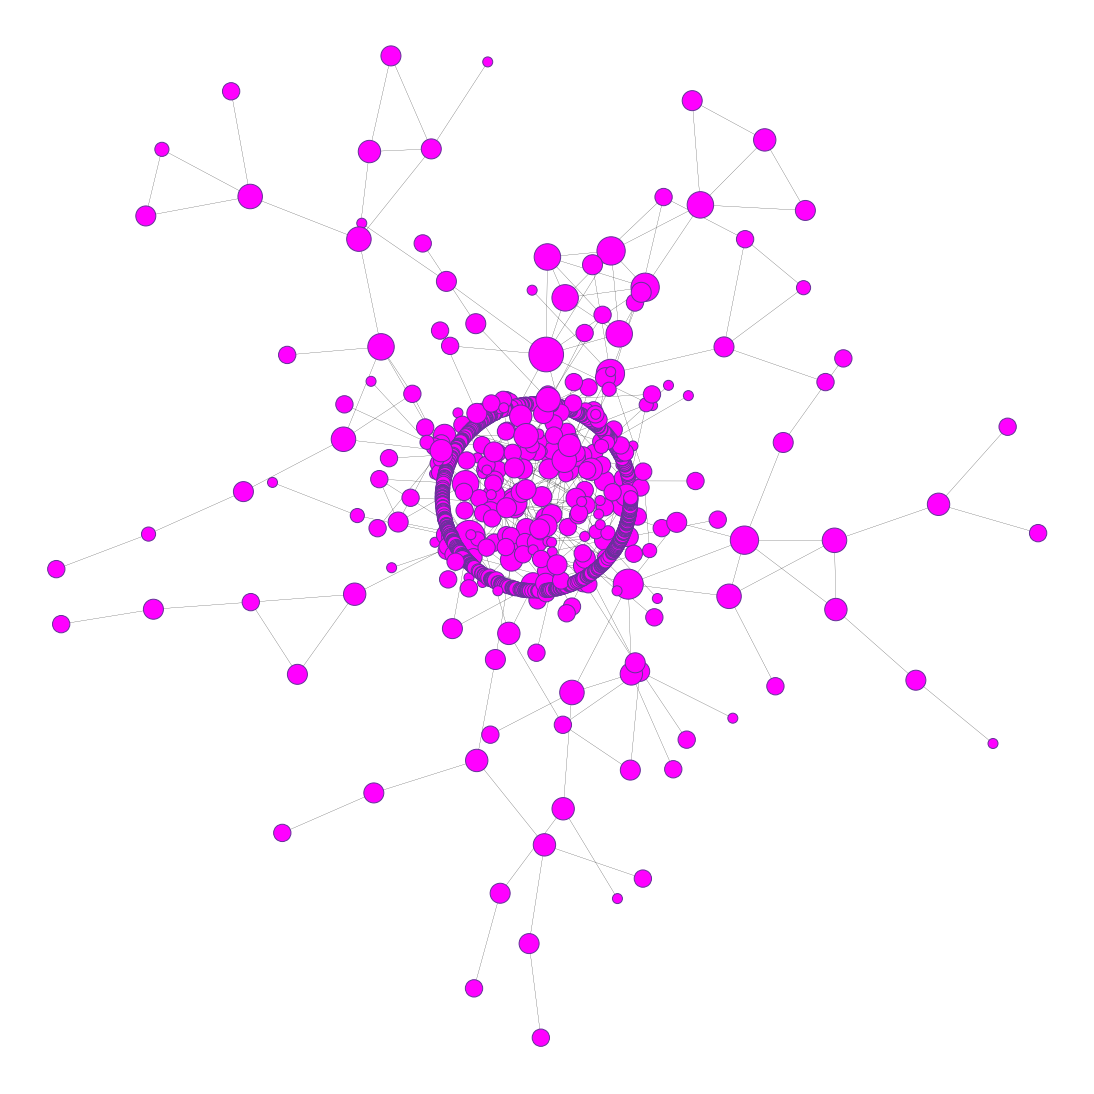

In [16]:
# Node size according to each node's degree

plt.rcParams["figure.figsize"] = (15,15)
nx.draw(G, pos, node_size=[deg* 100 for deg in degrees.values()], node_color='fuchsia', edgecolors='rebeccapurple', width=0.2)
#nx.draw(G, pos, node_size=100, node_color='fuchsia', edgecolors='#fcff52', width=0.2)

plt.show()

## 2.2 Network Analysis
To get a proper insight to the scale of the product network, we decided to make the complete network and orders graph for analysis purposes such as degree distribution and product connectivity.
### 2.2.1 Graph Generation (All products)
For the graph generating of all the product we will make a MultiGraph, which means that we allow multiple edges between two products. This is valid because two products can be bought together in multiple orders.

In [17]:
list1 = data['order_id']

In [31]:
G2 = nx.MultiGraph()
progress = 0
for index, row in data.iterrows():
    product = row['product_id']
    pri = row['price']
    order = row['order_id']
    G2.add_node(product, price = pri) #adding a node with the price attribute
    temp = 0
    for i in list1:
        if order == i:
            G2.add_edge(product, data['product_id'][temp])
        temp += 1
    progress +=1
    print(progress)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064


3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706


5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345


6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986
6987
6988


8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630


10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
10222
10223
10224
10225
10226
10227
10228
1022

11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
1159

12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
1296

14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
14324
14325
14326
14327
14328
14329
14330
14331
14332
14333
14334
14335
1433

15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
15691
15692
15693
15694
15695
15696
15697
15698
15699
15700
15701
15702
15703
15704
15705
15706
15707
1570

16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
1707

18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
18428
18429
18430
18431
18432
18433
18434
18435
18436
18437
18438
18439
18440
18441
18442
1844

19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
19797
19798
19799
19800
19801
19802
19803
19804
19805
19806
19807
19808
19809
19810
1981

21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
21167
21168
21169
21170
21171
21172
21173
21174
21175
21176
2117

22377
22378
22379
22380
22381
22382
22383
22384
22385
22386
22387
22388
22389
22390
22391
22392
22393
22394
22395
22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
22534
22535
22536
22537
22538
22539
22540
22541
22542
2254

23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
23900
23901
23902
23903
23904
23905
23906
23907
23908
23909
23910
23911
23912
23913
2391

25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
25267
25268
25269
25270
25271
25272
25273
25274
25275
25276
25277
25278
25279
25280
25281
2528

26485
26486
26487
26488
26489
26490
26491
26492
26493
26494
26495
26496
26497
26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
26634
26635
26636
26637
26638
26639
26640
26641
26642
26643
26644
26645
26646
26647
26648
26649
26650
2665

27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
28003
28004
28005
28006
28007
28008
28009
28010
28011
28012
28013
28014
28015
28016
28017
2801

29222
29223
29224
29225
29226
29227
29228
29229
29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
29257
29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
29370
29371
29372
29373
29374
29375
29376
29377
29378
29379
29380
29381
29382
29383
29384
29385
29386
29387
2938

30590
30591
30592
30593
30594
30595
30596
30597
30598
30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
30738
30739
30740
30741
30742
30743
30744
30745
30746
30747
30748
30749
30750
30751
30752
30753
30754
30755
3075

31956
31957
31958
31959
31960
31961
31962
31963
31964
31965
31966
31967
31968
31969
31970
31971
31972
31973
31974
31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997
31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
32107
32108
32109
32110
32111
32112
32113
32114
32115
32116
32117
32118
32119
32120
32121
3212

33324
33325
33326
33327
33328
33329
33330
33331
33332
33333
33334
33335
33336
33337
33338
33339
33340
33341
33342
33343
33344
33345
33346
33347
33348
33349
33350
33351
33352
33353
33354
33355
33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
33374
33375
33376
33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
33474
33475
33476
33477
33478
33479
33480
33481
33482
33483
33484
33485
33486
33487
33488
33489
3349

34689
34690
34691
34692
34693
34694
34695
34696
34697
34698
34699
34700
34701
34702
34703
34704
34705
34706
34707
34708
34709
34710
34711
34712
34713
34714
34715
34716
34717
34718
34719
34720
34721
34722
34723
34724
34725
34726
34727
34728
34729
34730
34731
34732
34733
34734
34735
34736
34737
34738
34739
34740
34741
34742
34743
34744
34745
34746
34747
34748
34749
34750
34751
34752
34753
34754
34755
34756
34757
34758
34759
34760
34761
34762
34763
34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
34840
34841
34842
34843
34844
34845
34846
34847
34848
34849
34850
34851
34852
34853
34854
3485

36061
36062
36063
36064
36065
36066
36067
36068
36069
36070
36071
36072
36073
36074
36075
36076
36077
36078
36079
36080
36081
36082
36083
36084
36085
36086
36087
36088
36089
36090
36091
36092
36093
36094
36095
36096
36097
36098
36099
36100
36101
36102
36103
36104
36105
36106
36107
36108
36109
36110
36111
36112
36113
36114
36115
36116
36117
36118
36119
36120
36121
36122
36123
36124
36125
36126
36127
36128
36129
36130
36131
36132
36133
36134
36135
36136
36137
36138
36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
36206
36207
36208
36209
36210
36211
36212
36213
36214
36215
36216
36217
36218
36219
36220
36221
36222
36223
36224
36225
36226
3622

37427
37428
37429
37430
37431
37432
37433
37434
37435
37436
37437
37438
37439
37440
37441
37442
37443
37444
37445
37446
37447
37448
37449
37450
37451
37452
37453
37454
37455
37456
37457
37458
37459
37460
37461
37462
37463
37464
37465
37466
37467
37468
37469
37470
37471
37472
37473
37474
37475
37476
37477
37478
37479
37480
37481
37482
37483
37484
37485
37486
37487
37488
37489
37490
37491
37492
37493
37494
37495
37496
37497
37498
37499
37500
37501
37502
37503
37504
37505
37506
37507
37508
37509
37510
37511
37512
37513
37514
37515
37516
37517
37518
37519
37520
37521
37522
37523
37524
37525
37526
37527
37528
37529
37530
37531
37532
37533
37534
37535
37536
37537
37538
37539
37540
37541
37542
37543
37544
37545
37546
37547
37548
37549
37550
37551
37552
37553
37554
37555
37556
37557
37558
37559
37560
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
37573
37574
37575
37576
37577
37578
37579
37580
37581
37582
37583
37584
37585
37586
37587
37588
37589
37590
37591
37592
3759

38796
38797
38798
38799
38800
38801
38802
38803
38804
38805
38806
38807
38808
38809
38810
38811
38812
38813
38814
38815
38816
38817
38818
38819
38820
38821
38822
38823
38824
38825
38826
38827
38828
38829
38830
38831
38832
38833
38834
38835
38836
38837
38838
38839
38840
38841
38842
38843
38844
38845
38846
38847
38848
38849
38850
38851
38852
38853
38854
38855
38856
38857
38858
38859
38860
38861
38862
38863
38864
38865
38866
38867
38868
38869
38870
38871
38872
38873
38874
38875
38876
38877
38878
38879
38880
38881
38882
38883
38884
38885
38886
38887
38888
38889
38890
38891
38892
38893
38894
38895
38896
38897
38898
38899
38900
38901
38902
38903
38904
38905
38906
38907
38908
38909
38910
38911
38912
38913
38914
38915
38916
38917
38918
38919
38920
38921
38922
38923
38924
38925
38926
38927
38928
38929
38930
38931
38932
38933
38934
38935
38936
38937
38938
38939
38940
38941
38942
38943
38944
38945
38946
38947
38948
38949
38950
38951
38952
38953
38954
38955
38956
38957
38958
38959
38960
38961
3896

40164
40165
40166
40167
40168
40169
40170
40171
40172
40173
40174
40175
40176
40177
40178
40179
40180
40181
40182
40183
40184
40185
40186
40187
40188
40189
40190
40191
40192
40193
40194
40195
40196
40197
40198
40199
40200
40201
40202
40203
40204
40205
40206
40207
40208
40209
40210
40211
40212
40213
40214
40215
40216
40217
40218
40219
40220
40221
40222
40223
40224
40225
40226
40227
40228
40229
40230
40231
40232
40233
40234
40235
40236
40237
40238
40239
40240
40241
40242
40243
40244
40245
40246
40247
40248
40249
40250
40251
40252
40253
40254
40255
40256
40257
40258
40259
40260
40261
40262
40263
40264
40265
40266
40267
40268
40269
40270
40271
40272
40273
40274
40275
40276
40277
40278
40279
40280
40281
40282
40283
40284
40285
40286
40287
40288
40289
40290
40291
40292
40293
40294
40295
40296
40297
40298
40299
40300
40301
40302
40303
40304
40305
40306
40307
40308
40309
40310
40311
40312
40313
40314
40315
40316
40317
40318
40319
40320
40321
40322
40323
40324
40325
40326
40327
40328
40329
4033

41532
41533
41534
41535
41536
41537
41538
41539
41540
41541
41542
41543
41544
41545
41546
41547
41548
41549
41550
41551
41552
41553
41554
41555
41556
41557
41558
41559
41560
41561
41562
41563
41564
41565
41566
41567
41568
41569
41570
41571
41572
41573
41574
41575
41576
41577
41578
41579
41580
41581
41582
41583
41584
41585
41586
41587
41588
41589
41590
41591
41592
41593
41594
41595
41596
41597
41598
41599
41600
41601
41602
41603
41604
41605
41606
41607
41608
41609
41610
41611
41612
41613
41614
41615
41616
41617
41618
41619
41620
41621
41622
41623
41624
41625
41626
41627
41628
41629
41630
41631
41632
41633
41634
41635
41636
41637
41638
41639
41640
41641
41642
41643
41644
41645
41646
41647
41648
41649
41650
41651
41652
41653
41654
41655
41656
41657
41658
41659
41660
41661
41662
41663
41664
41665
41666
41667
41668
41669
41670
41671
41672
41673
41674
41675
41676
41677
41678
41679
41680
41681
41682
41683
41684
41685
41686
41687
41688
41689
41690
41691
41692
41693
41694
41695
41696
41697
4169

42898
42899
42900
42901
42902
42903
42904
42905
42906
42907
42908
42909
42910
42911
42912
42913
42914
42915
42916
42917
42918
42919
42920
42921
42922
42923
42924
42925
42926
42927
42928
42929
42930
42931
42932
42933
42934
42935
42936
42937
42938
42939
42940
42941
42942
42943
42944
42945
42946
42947
42948
42949
42950
42951
42952
42953
42954
42955
42956
42957
42958
42959
42960
42961
42962
42963
42964
42965
42966
42967
42968
42969
42970
42971
42972
42973
42974
42975
42976
42977
42978
42979
42980
42981
42982
42983
42984
42985
42986
42987
42988
42989
42990
42991
42992
42993
42994
42995
42996
42997
42998
42999
43000
43001
43002
43003
43004
43005
43006
43007
43008
43009
43010
43011
43012
43013
43014
43015
43016
43017
43018
43019
43020
43021
43022
43023
43024
43025
43026
43027
43028
43029
43030
43031
43032
43033
43034
43035
43036
43037
43038
43039
43040
43041
43042
43043
43044
43045
43046
43047
43048
43049
43050
43051
43052
43053
43054
43055
43056
43057
43058
43059
43060
43061
43062
43063
4306

44269
44270
44271
44272
44273
44274
44275
44276
44277
44278
44279
44280
44281
44282
44283
44284
44285
44286
44287
44288
44289
44290
44291
44292
44293
44294
44295
44296
44297
44298
44299
44300
44301
44302
44303
44304
44305
44306
44307
44308
44309
44310
44311
44312
44313
44314
44315
44316
44317
44318
44319
44320
44321
44322
44323
44324
44325
44326
44327
44328
44329
44330
44331
44332
44333
44334
44335
44336
44337
44338
44339
44340
44341
44342
44343
44344
44345
44346
44347
44348
44349
44350
44351
44352
44353
44354
44355
44356
44357
44358
44359
44360
44361
44362
44363
44364
44365
44366
44367
44368
44369
44370
44371
44372
44373
44374
44375
44376
44377
44378
44379
44380
44381
44382
44383
44384
44385
44386
44387
44388
44389
44390
44391
44392
44393
44394
44395
44396
44397
44398
44399
44400
44401
44402
44403
44404
44405
44406
44407
44408
44409
44410
44411
44412
44413
44414
44415
44416
44417
44418
44419
44420
44421
44422
44423
44424
44425
44426
44427
44428
44429
44430
44431
44432
44433
44434
4443

45638
45639
45640
45641
45642
45643
45644
45645
45646
45647
45648
45649
45650
45651
45652
45653
45654
45655
45656
45657
45658
45659
45660
45661
45662
45663
45664
45665
45666
45667
45668
45669
45670
45671
45672
45673
45674
45675
45676
45677
45678
45679
45680
45681
45682
45683
45684
45685
45686
45687
45688
45689
45690
45691
45692
45693
45694
45695
45696
45697
45698
45699
45700
45701
45702
45703
45704
45705
45706
45707
45708
45709
45710
45711
45712
45713
45714
45715
45716
45717
45718
45719
45720
45721
45722
45723
45724
45725
45726
45727
45728
45729
45730
45731
45732
45733
45734
45735
45736
45737
45738
45739
45740
45741
45742
45743
45744
45745
45746
45747
45748
45749
45750
45751
45752
45753
45754
45755
45756
45757
45758
45759
45760
45761
45762
45763
45764
45765
45766
45767
45768
45769
45770
45771
45772
45773
45774
45775
45776
45777
45778
45779
45780
45781
45782
45783
45784
45785
45786
45787
45788
45789
45790
45791
45792
45793
45794
45795
45796
45797
45798
45799
45800
45801
45802
45803
4580

47004
47005
47006
47007
47008
47009
47010
47011
47012
47013
47014
47015
47016
47017
47018
47019
47020
47021
47022
47023
47024
47025
47026
47027
47028
47029
47030
47031
47032
47033
47034
47035
47036
47037
47038
47039
47040
47041
47042
47043
47044
47045
47046
47047
47048
47049
47050
47051
47052
47053
47054
47055
47056
47057
47058
47059
47060
47061
47062
47063
47064
47065
47066
47067
47068
47069
47070
47071
47072
47073
47074
47075
47076
47077
47078
47079
47080
47081
47082
47083
47084
47085
47086
47087
47088
47089
47090
47091
47092
47093
47094
47095
47096
47097
47098
47099
47100
47101
47102
47103
47104
47105
47106
47107
47108
47109
47110
47111
47112
47113
47114
47115
47116
47117
47118
47119
47120
47121
47122
47123
47124
47125
47126
47127
47128
47129
47130
47131
47132
47133
47134
47135
47136
47137
47138
47139
47140
47141
47142
47143
47144
47145
47146
47147
47148
47149
47150
47151
47152
47153
47154
47155
47156
47157
47158
47159
47160
47161
47162
47163
47164
47165
47166
47167
47168
47169
4717

48370
48371
48372
48373
48374
48375
48376
48377
48378
48379
48380
48381
48382
48383
48384
48385
48386
48387
48388
48389
48390
48391
48392
48393
48394
48395
48396
48397
48398
48399
48400
48401
48402
48403
48404
48405
48406
48407
48408
48409
48410
48411
48412
48413
48414
48415
48416
48417
48418
48419
48420
48421
48422
48423
48424
48425
48426
48427
48428
48429
48430
48431
48432
48433
48434
48435
48436
48437
48438
48439
48440
48441
48442
48443
48444
48445
48446
48447
48448
48449
48450
48451
48452
48453
48454
48455
48456
48457
48458
48459
48460
48461
48462
48463
48464
48465
48466
48467
48468
48469
48470
48471
48472
48473
48474
48475
48476
48477
48478
48479
48480
48481
48482
48483
48484
48485
48486
48487
48488
48489
48490
48491
48492
48493
48494
48495
48496
48497
48498
48499
48500
48501
48502
48503
48504
48505
48506
48507
48508
48509
48510
48511
48512
48513
48514
48515
48516
48517
48518
48519
48520
48521
48522
48523
48524
48525
48526
48527
48528
48529
48530
48531
48532
48533
48534
48535
4853

49737
49738
49739
49740
49741
49742
49743
49744
49745
49746
49747
49748
49749
49750
49751
49752
49753
49754
49755
49756
49757
49758
49759
49760
49761
49762
49763
49764
49765
49766
49767
49768
49769
49770
49771
49772
49773
49774
49775
49776
49777
49778
49779
49780
49781
49782
49783
49784
49785
49786
49787
49788
49789
49790
49791
49792
49793
49794
49795
49796
49797
49798
49799
49800
49801
49802
49803
49804
49805
49806
49807
49808
49809
49810
49811
49812
49813
49814
49815
49816
49817
49818
49819
49820
49821
49822
49823
49824
49825
49826
49827
49828
49829
49830
49831
49832
49833
49834
49835
49836
49837
49838
49839
49840
49841
49842
49843
49844
49845
49846
49847
49848
49849
49850
49851
49852
49853
49854
49855
49856
49857
49858
49859
49860
49861
49862
49863
49864
49865
49866
49867
49868
49869
49870
49871
49872
49873
49874
49875
49876
49877
49878
49879
49880
49881
49882
49883
49884
49885
49886
49887
49888
49889
49890
49891
49892
49893
49894
49895
49896
49897
49898
49899
49900
49901
49902
4990

51105
51106
51107
51108
51109
51110
51111
51112
51113
51114
51115
51116
51117
51118
51119
51120
51121
51122
51123
51124
51125
51126
51127
51128
51129
51130
51131
51132
51133
51134
51135
51136
51137
51138
51139
51140
51141
51142
51143
51144
51145
51146
51147
51148
51149
51150
51151
51152
51153
51154
51155
51156
51157
51158
51159
51160
51161
51162
51163
51164
51165
51166
51167
51168
51169
51170
51171
51172
51173
51174
51175
51176
51177
51178
51179
51180
51181
51182
51183
51184
51185
51186
51187
51188
51189
51190
51191
51192
51193
51194
51195
51196
51197
51198
51199
51200
51201
51202
51203
51204
51205
51206
51207
51208
51209
51210
51211
51212
51213
51214
51215
51216
51217
51218
51219
51220
51221
51222
51223
51224
51225
51226
51227
51228
51229
51230
51231
51232
51233
51234
51235
51236
51237
51238
51239
51240
51241
51242
51243
51244
51245
51246
51247
51248
51249
51250
51251
51252
51253
51254
51255
51256
51257
51258
51259
51260
51261
51262
51263
51264
51265
51266
51267
51268
51269
51270
5127

52472
52473
52474
52475
52476
52477
52478
52479
52480
52481
52482
52483
52484
52485
52486
52487
52488
52489
52490
52491
52492
52493
52494
52495
52496
52497
52498
52499
52500
52501
52502
52503
52504
52505
52506
52507
52508
52509
52510
52511
52512
52513
52514
52515
52516
52517
52518
52519
52520
52521
52522
52523
52524
52525
52526
52527
52528
52529
52530
52531
52532
52533
52534
52535
52536
52537
52538
52539
52540
52541
52542
52543
52544
52545
52546
52547
52548
52549
52550
52551
52552
52553
52554
52555
52556
52557
52558
52559
52560
52561
52562
52563
52564
52565
52566
52567
52568
52569
52570
52571
52572
52573
52574
52575
52576
52577
52578
52579
52580
52581
52582
52583
52584
52585
52586
52587
52588
52589
52590
52591
52592
52593
52594
52595
52596
52597
52598
52599
52600
52601
52602
52603
52604
52605
52606
52607
52608
52609
52610
52611
52612
52613
52614
52615
52616
52617
52618
52619
52620
52621
52622
52623
52624
52625
52626
52627
52628
52629
52630
52631
52632
52633
52634
52635
52636
52637
5263

53842
53843
53844
53845
53846
53847
53848
53849
53850
53851
53852
53853
53854
53855
53856
53857
53858
53859
53860
53861
53862
53863
53864
53865
53866
53867
53868
53869
53870
53871
53872
53873
53874
53875
53876
53877
53878
53879
53880
53881
53882
53883
53884
53885
53886
53887
53888
53889
53890
53891
53892
53893
53894
53895
53896
53897
53898
53899
53900
53901
53902
53903
53904
53905
53906
53907
53908
53909
53910
53911
53912
53913
53914
53915
53916
53917
53918
53919
53920
53921
53922
53923
53924
53925
53926
53927
53928
53929
53930
53931
53932
53933
53934
53935
53936
53937
53938
53939
53940
53941
53942
53943
53944
53945
53946
53947
53948
53949
53950
53951
53952
53953
53954
53955
53956
53957
53958
53959
53960
53961
53962
53963
53964
53965
53966
53967
53968
53969
53970
53971
53972
53973
53974
53975
53976
53977
53978
53979
53980
53981
53982
53983
53984
53985
53986
53987
53988
53989
53990
53991
53992
53993
53994
53995
53996
53997
53998
53999
54000
54001
54002
54003
54004
54005
54006
54007
5400

55211
55212
55213
55214
55215
55216
55217
55218
55219
55220
55221
55222
55223
55224
55225
55226
55227
55228
55229
55230
55231
55232
55233
55234
55235
55236
55237
55238
55239
55240
55241
55242
55243
55244
55245
55246
55247
55248
55249
55250
55251
55252
55253
55254
55255
55256
55257
55258
55259
55260
55261
55262
55263
55264
55265
55266
55267
55268
55269
55270
55271
55272
55273
55274
55275
55276
55277
55278
55279
55280
55281
55282
55283
55284
55285
55286
55287
55288
55289
55290
55291
55292
55293
55294
55295
55296
55297
55298
55299
55300
55301
55302
55303
55304
55305
55306
55307
55308
55309
55310
55311
55312
55313
55314
55315
55316
55317
55318
55319
55320
55321
55322
55323
55324
55325
55326
55327
55328
55329
55330
55331
55332
55333
55334
55335
55336
55337
55338
55339
55340
55341
55342
55343
55344
55345
55346
55347
55348
55349
55350
55351
55352
55353
55354
55355
55356
55357
55358
55359
55360
55361
55362
55363
55364
55365
55366
55367
55368
55369
55370
55371
55372
55373
55374
55375
55376
5537

56578
56579
56580
56581
56582
56583
56584
56585
56586
56587
56588
56589
56590
56591
56592
56593
56594
56595
56596
56597
56598
56599
56600
56601
56602
56603
56604
56605
56606
56607
56608
56609
56610
56611
56612
56613
56614
56615
56616
56617
56618
56619
56620
56621
56622
56623
56624
56625
56626
56627
56628
56629
56630
56631
56632
56633
56634
56635
56636
56637
56638
56639
56640
56641
56642
56643
56644
56645
56646
56647
56648
56649
56650
56651
56652
56653
56654
56655
56656
56657
56658
56659
56660
56661
56662
56663
56664
56665
56666
56667
56668
56669
56670
56671
56672
56673
56674
56675
56676
56677
56678
56679
56680
56681
56682
56683
56684
56685
56686
56687
56688
56689
56690
56691
56692
56693
56694
56695
56696
56697
56698
56699
56700
56701
56702
56703
56704
56705
56706
56707
56708
56709
56710
56711
56712
56713
56714
56715
56716
56717
56718
56719
56720
56721
56722
56723
56724
56725
56726
56727
56728
56729
56730
56731
56732
56733
56734
56735
56736
56737
56738
56739
56740
56741
56742
56743
5674

57944
57945
57946
57947
57948
57949
57950
57951
57952
57953
57954
57955
57956
57957
57958
57959
57960
57961
57962
57963
57964
57965
57966
57967
57968
57969
57970
57971
57972
57973
57974
57975
57976
57977
57978
57979
57980
57981
57982
57983
57984
57985
57986
57987
57988
57989
57990
57991
57992
57993
57994
57995
57996
57997
57998
57999
58000
58001
58002
58003
58004
58005
58006
58007
58008
58009
58010
58011
58012
58013
58014
58015
58016
58017
58018
58019
58020
58021
58022
58023
58024
58025
58026
58027
58028
58029
58030
58031
58032
58033
58034
58035
58036
58037
58038
58039
58040
58041
58042
58043
58044
58045
58046
58047
58048
58049
58050
58051
58052
58053
58054
58055
58056
58057
58058
58059
58060
58061
58062
58063
58064
58065
58066
58067
58068
58069
58070
58071
58072
58073
58074
58075
58076
58077
58078
58079
58080
58081
58082
58083
58084
58085
58086
58087
58088
58089
58090
58091
58092
58093
58094
58095
58096
58097
58098
58099
58100
58101
58102
58103
58104
58105
58106
58107
58108
58109
5811

59313
59314
59315
59316
59317
59318
59319
59320
59321
59322
59323
59324
59325
59326
59327
59328
59329
59330
59331
59332
59333
59334
59335
59336
59337
59338
59339
59340
59341
59342
59343
59344
59345
59346
59347
59348
59349
59350
59351
59352
59353
59354
59355
59356
59357
59358
59359
59360
59361
59362
59363
59364
59365
59366
59367
59368
59369
59370
59371
59372
59373
59374
59375
59376
59377
59378
59379
59380
59381
59382
59383
59384
59385
59386
59387
59388
59389
59390
59391
59392
59393
59394
59395
59396
59397
59398
59399
59400
59401
59402
59403
59404
59405
59406
59407
59408
59409
59410
59411
59412
59413
59414
59415
59416
59417
59418
59419
59420
59421
59422
59423
59424
59425
59426
59427
59428
59429
59430
59431
59432
59433
59434
59435
59436
59437
59438
59439
59440
59441
59442
59443
59444
59445
59446
59447
59448
59449
59450
59451
59452
59453
59454
59455
59456
59457
59458
59459
59460
59461
59462
59463
59464
59465
59466
59467
59468
59469
59470
59471
59472
59473
59474
59475
59476
59477
59478
5947

60683
60684
60685
60686
60687
60688
60689
60690
60691
60692
60693
60694
60695
60696
60697
60698
60699
60700
60701
60702
60703
60704
60705
60706
60707
60708
60709
60710
60711
60712
60713
60714
60715
60716
60717
60718
60719
60720
60721
60722
60723
60724
60725
60726
60727
60728
60729
60730
60731
60732
60733
60734
60735
60736
60737
60738
60739
60740
60741
60742
60743
60744
60745
60746
60747
60748
60749
60750
60751
60752
60753
60754
60755
60756
60757
60758
60759
60760
60761
60762
60763
60764
60765
60766
60767
60768
60769
60770
60771
60772
60773
60774
60775
60776
60777
60778
60779
60780
60781
60782
60783
60784
60785
60786
60787
60788
60789
60790
60791
60792
60793
60794
60795
60796
60797
60798
60799
60800
60801
60802
60803
60804
60805
60806
60807
60808
60809
60810
60811
60812
60813
60814
60815
60816
60817
60818
60819
60820
60821
60822
60823
60824
60825
60826
60827
60828
60829
60830
60831
60832
60833
60834
60835
60836
60837
60838
60839
60840
60841
60842
60843
60844
60845
60846
60847
60848
6084

62048
62049
62050
62051
62052
62053
62054
62055
62056
62057
62058
62059
62060
62061
62062
62063
62064
62065
62066
62067
62068
62069
62070
62071
62072
62073
62074
62075
62076
62077
62078
62079
62080
62081
62082
62083
62084
62085
62086
62087
62088
62089
62090
62091
62092
62093
62094
62095
62096
62097
62098
62099
62100
62101
62102
62103
62104
62105
62106
62107
62108
62109
62110
62111
62112
62113
62114
62115
62116
62117
62118
62119
62120
62121
62122
62123
62124
62125
62126
62127
62128
62129
62130
62131
62132
62133
62134
62135
62136
62137
62138
62139
62140
62141
62142
62143
62144
62145
62146
62147
62148
62149
62150
62151
62152
62153
62154
62155
62156
62157
62158
62159
62160
62161
62162
62163
62164
62165
62166
62167
62168
62169
62170
62171
62172
62173
62174
62175
62176
62177
62178
62179
62180
62181
62182
62183
62184
62185
62186
62187
62188
62189
62190
62191
62192
62193
62194
62195
62196
62197
62198
62199
62200
62201
62202
62203
62204
62205
62206
62207
62208
62209
62210
62211
62212
62213
6221

63421
63422
63423
63424
63425
63426
63427
63428
63429
63430
63431
63432
63433
63434
63435
63436
63437
63438
63439
63440
63441
63442
63443
63444
63445
63446
63447
63448
63449
63450
63451
63452
63453
63454
63455
63456
63457
63458
63459
63460
63461
63462
63463
63464
63465
63466
63467
63468
63469
63470
63471
63472
63473
63474
63475
63476
63477
63478
63479
63480
63481
63482
63483
63484
63485
63486
63487
63488
63489
63490
63491
63492
63493
63494
63495
63496
63497
63498
63499
63500
63501
63502
63503
63504
63505
63506
63507
63508
63509
63510
63511
63512
63513
63514
63515
63516
63517
63518
63519
63520
63521
63522
63523
63524
63525
63526
63527
63528
63529
63530
63531
63532
63533
63534
63535
63536
63537
63538
63539
63540
63541
63542
63543
63544
63545
63546
63547
63548
63549
63550
63551
63552
63553
63554
63555
63556
63557
63558
63559
63560
63561
63562
63563
63564
63565
63566
63567
63568
63569
63570
63571
63572
63573
63574
63575
63576
63577
63578
63579
63580
63581
63582
63583
63584
63585
63586
6358

64789
64790
64791
64792
64793
64794
64795
64796
64797
64798
64799
64800
64801
64802
64803
64804
64805
64806
64807
64808
64809
64810
64811
64812
64813
64814
64815
64816
64817
64818
64819
64820
64821
64822
64823
64824
64825
64826
64827
64828
64829
64830
64831
64832
64833
64834
64835
64836
64837
64838
64839
64840
64841
64842
64843
64844
64845
64846
64847
64848
64849
64850
64851
64852
64853
64854
64855
64856
64857
64858
64859
64860
64861
64862
64863
64864
64865
64866
64867
64868
64869
64870
64871
64872
64873
64874
64875
64876
64877
64878
64879
64880
64881
64882
64883
64884
64885
64886
64887
64888
64889
64890
64891
64892
64893
64894
64895
64896
64897
64898
64899
64900
64901
64902
64903
64904
64905
64906
64907
64908
64909
64910
64911
64912
64913
64914
64915
64916
64917
64918
64919
64920
64921
64922
64923
64924
64925
64926
64927
64928
64929
64930
64931
64932
64933
64934
64935
64936
64937
64938
64939
64940
64941
64942
64943
64944
64945
64946
64947
64948
64949
64950
64951
64952
64953
64954
6495

66161
66162
66163
66164
66165
66166
66167
66168
66169
66170
66171
66172
66173
66174
66175
66176
66177
66178
66179
66180
66181
66182
66183
66184
66185
66186
66187
66188
66189
66190
66191
66192
66193
66194
66195
66196
66197
66198
66199
66200
66201
66202
66203
66204
66205
66206
66207
66208
66209
66210
66211
66212
66213
66214
66215
66216
66217
66218
66219
66220
66221
66222
66223
66224
66225
66226
66227
66228
66229
66230
66231
66232
66233
66234
66235
66236
66237
66238
66239
66240
66241
66242
66243
66244
66245
66246
66247
66248
66249
66250
66251
66252
66253
66254
66255
66256
66257
66258
66259
66260
66261
66262
66263
66264
66265
66266
66267
66268
66269
66270
66271
66272
66273
66274
66275
66276
66277
66278
66279
66280
66281
66282
66283
66284
66285
66286
66287
66288
66289
66290
66291
66292
66293
66294
66295
66296
66297
66298
66299
66300
66301
66302
66303
66304
66305
66306
66307
66308
66309
66310
66311
66312
66313
66314
66315
66316
66317
66318
66319
66320
66321
66322
66323
66324
66325
66326
6632

67530
67531
67532
67533
67534
67535
67536
67537
67538
67539
67540
67541
67542
67543
67544
67545
67546
67547
67548
67549
67550
67551
67552
67553
67554
67555
67556
67557
67558
67559
67560
67561
67562
67563
67564
67565
67566
67567
67568
67569
67570
67571
67572
67573
67574
67575
67576
67577
67578
67579
67580
67581
67582
67583
67584
67585
67586
67587
67588
67589
67590
67591
67592
67593
67594
67595
67596
67597
67598
67599
67600
67601
67602
67603
67604
67605
67606
67607
67608
67609
67610
67611
67612
67613
67614
67615
67616
67617
67618
67619
67620
67621
67622
67623
67624
67625
67626
67627
67628
67629
67630
67631
67632
67633
67634
67635
67636
67637
67638
67639
67640
67641
67642
67643
67644
67645
67646
67647
67648
67649
67650
67651
67652
67653
67654
67655
67656
67657
67658
67659
67660
67661
67662
67663
67664
67665
67666
67667
67668
67669
67670
67671
67672
67673
67674
67675
67676
67677
67678
67679
67680
67681
67682
67683
67684
67685
67686
67687
67688
67689
67690
67691
67692
67693
67694
67695
6769

68899
68900
68901
68902
68903
68904
68905
68906
68907
68908
68909
68910
68911
68912
68913
68914
68915
68916
68917
68918
68919
68920
68921
68922
68923
68924
68925
68926
68927
68928
68929
68930
68931
68932
68933
68934
68935
68936
68937
68938
68939
68940
68941
68942
68943
68944
68945
68946
68947
68948
68949
68950
68951
68952
68953
68954
68955
68956
68957
68958
68959
68960
68961
68962
68963
68964
68965
68966
68967
68968
68969
68970
68971
68972
68973
68974
68975
68976
68977
68978
68979
68980
68981
68982
68983
68984
68985
68986
68987
68988
68989
68990
68991
68992
68993
68994
68995
68996
68997
68998
68999
69000
69001
69002
69003
69004
69005
69006
69007
69008
69009
69010
69011
69012
69013
69014
69015
69016
69017
69018
69019
69020
69021
69022
69023
69024
69025
69026
69027
69028
69029
69030
69031
69032
69033
69034
69035
69036
69037
69038
69039
69040
69041
69042
69043
69044
69045
69046
69047
69048
69049
69050
69051
69052
69053
69054
69055
69056
69057
69058
69059
69060
69061
69062
69063
69064
6906

70270
70271
70272
70273
70274
70275
70276
70277
70278
70279
70280
70281
70282
70283
70284
70285
70286
70287
70288
70289
70290
70291
70292
70293
70294
70295
70296
70297
70298
70299
70300
70301
70302
70303
70304
70305
70306
70307
70308
70309
70310
70311
70312
70313
70314
70315
70316
70317
70318
70319
70320
70321
70322
70323
70324
70325
70326
70327
70328
70329
70330
70331
70332
70333
70334
70335
70336
70337
70338
70339
70340
70341
70342
70343
70344
70345
70346
70347
70348
70349
70350
70351
70352
70353
70354
70355
70356
70357
70358
70359
70360
70361
70362
70363
70364
70365
70366
70367
70368
70369
70370
70371
70372
70373
70374
70375
70376
70377
70378
70379
70380
70381
70382
70383
70384
70385
70386
70387
70388
70389
70390
70391
70392
70393
70394
70395
70396
70397
70398
70399
70400
70401
70402
70403
70404
70405
70406
70407
70408
70409
70410
70411
70412
70413
70414
70415
70416
70417
70418
70419
70420
70421
70422
70423
70424
70425
70426
70427
70428
70429
70430
70431
70432
70433
70434
70435
7043

71637
71638
71639
71640
71641
71642
71643
71644
71645
71646
71647
71648
71649
71650
71651
71652
71653
71654
71655
71656
71657
71658
71659
71660
71661
71662
71663
71664
71665
71666
71667
71668
71669
71670
71671
71672
71673
71674
71675
71676
71677
71678
71679
71680
71681
71682
71683
71684
71685
71686
71687
71688
71689
71690
71691
71692
71693
71694
71695
71696
71697
71698
71699
71700
71701
71702
71703
71704
71705
71706
71707
71708
71709
71710
71711
71712
71713
71714
71715
71716
71717
71718
71719
71720
71721
71722
71723
71724
71725
71726
71727
71728
71729
71730
71731
71732
71733
71734
71735
71736
71737
71738
71739
71740
71741
71742
71743
71744
71745
71746
71747
71748
71749
71750
71751
71752
71753
71754
71755
71756
71757
71758
71759
71760
71761
71762
71763
71764
71765
71766
71767
71768
71769
71770
71771
71772
71773
71774
71775
71776
71777
71778
71779
71780
71781
71782
71783
71784
71785
71786
71787
71788
71789
71790
71791
71792
71793
71794
71795
71796
71797
71798
71799
71800
71801
71802
7180

73008
73009
73010
73011
73012
73013
73014
73015
73016
73017
73018
73019
73020
73021
73022
73023
73024
73025
73026
73027
73028
73029
73030
73031
73032
73033
73034
73035
73036
73037
73038
73039
73040
73041
73042
73043
73044
73045
73046
73047
73048
73049
73050
73051
73052
73053
73054
73055
73056
73057
73058
73059
73060
73061
73062
73063
73064
73065
73066
73067
73068
73069
73070
73071
73072
73073
73074
73075
73076
73077
73078
73079
73080
73081
73082
73083
73084
73085
73086
73087
73088
73089
73090
73091
73092
73093
73094
73095
73096
73097
73098
73099
73100
73101
73102
73103
73104
73105
73106
73107
73108
73109
73110
73111
73112
73113
73114
73115
73116
73117
73118
73119
73120
73121
73122
73123
73124
73125
73126
73127
73128
73129
73130
73131
73132
73133
73134
73135
73136
73137
73138
73139
73140
73141
73142
73143
73144
73145
73146
73147
73148
73149
73150
73151
73152
73153
73154
73155
73156
73157
73158
73159
73160
73161
73162
73163
73164
73165
73166
73167
73168
73169
73170
73171
73172
73173
7317

74376
74377
74378
74379
74380
74381
74382
74383
74384
74385
74386
74387
74388
74389
74390
74391
74392
74393
74394
74395
74396
74397
74398
74399
74400
74401
74402
74403
74404
74405
74406
74407
74408
74409
74410
74411
74412
74413
74414
74415
74416
74417
74418
74419
74420
74421
74422
74423
74424
74425
74426
74427
74428
74429
74430
74431
74432
74433
74434
74435
74436
74437
74438
74439
74440
74441
74442
74443
74444
74445
74446
74447
74448
74449
74450
74451
74452
74453
74454
74455
74456
74457
74458
74459
74460
74461
74462
74463
74464
74465
74466
74467
74468
74469
74470
74471
74472
74473
74474
74475
74476
74477
74478
74479
74480
74481
74482
74483
74484
74485
74486
74487
74488
74489
74490
74491
74492
74493
74494
74495
74496
74497
74498
74499
74500
74501
74502
74503
74504
74505
74506
74507
74508
74509
74510
74511
74512
74513
74514
74515
74516
74517
74518
74519
74520
74521
74522
74523
74524
74525
74526
74527
74528
74529
74530
74531
74532
74533
74534
74535
74536
74537
74538
74539
74540
74541
7454

75746
75747
75748
75749
75750
75751
75752
75753
75754
75755
75756
75757
75758
75759
75760
75761
75762
75763
75764
75765
75766
75767
75768
75769
75770
75771
75772
75773
75774
75775
75776
75777
75778
75779
75780
75781
75782
75783
75784
75785
75786
75787
75788
75789
75790
75791
75792
75793
75794
75795
75796
75797
75798
75799
75800
75801
75802
75803
75804
75805
75806
75807
75808
75809
75810
75811
75812
75813
75814
75815
75816
75817
75818
75819
75820
75821
75822
75823
75824
75825
75826
75827
75828
75829
75830
75831
75832
75833
75834
75835
75836
75837
75838
75839
75840
75841
75842
75843
75844
75845
75846
75847
75848
75849
75850
75851
75852
75853
75854
75855
75856
75857
75858
75859
75860
75861
75862
75863
75864
75865
75866
75867
75868
75869
75870
75871
75872
75873
75874
75875
75876
75877
75878
75879
75880
75881
75882
75883
75884
75885
75886
75887
75888
75889
75890
75891
75892
75893
75894
75895
75896
75897
75898
75899
75900
75901
75902
75903
75904
75905
75906
75907
75908
75909
75910
75911
7591

77113
77114
77115
77116
77117
77118
77119
77120
77121
77122
77123
77124
77125
77126
77127
77128
77129
77130
77131
77132
77133
77134
77135
77136
77137
77138
77139
77140
77141
77142
77143
77144
77145
77146
77147
77148
77149
77150
77151
77152
77153
77154
77155
77156
77157
77158
77159
77160
77161
77162
77163
77164
77165
77166
77167
77168
77169
77170
77171
77172
77173
77174
77175
77176
77177
77178
77179
77180
77181
77182
77183
77184
77185
77186
77187
77188
77189
77190
77191
77192
77193
77194
77195
77196
77197
77198
77199
77200
77201
77202
77203
77204
77205
77206
77207
77208
77209
77210
77211
77212
77213
77214
77215
77216
77217
77218
77219
77220
77221
77222
77223
77224
77225
77226
77227
77228
77229
77230
77231
77232
77233
77234
77235
77236
77237
77238
77239
77240
77241
77242
77243
77244
77245
77246
77247
77248
77249
77250
77251
77252
77253
77254
77255
77256
77257
77258
77259
77260
77261
77262
77263
77264
77265
77266
77267
77268
77269
77270
77271
77272
77273
77274
77275
77276
77277
77278
7727

78482
78483
78484
78485
78486
78487
78488
78489
78490
78491
78492
78493
78494
78495
78496
78497
78498
78499
78500
78501
78502
78503
78504
78505
78506
78507
78508
78509
78510
78511
78512
78513
78514
78515
78516
78517
78518
78519
78520
78521
78522
78523
78524
78525
78526
78527
78528
78529
78530
78531
78532
78533
78534
78535
78536
78537
78538
78539
78540
78541
78542
78543
78544
78545
78546
78547
78548
78549
78550
78551
78552
78553
78554
78555
78556
78557
78558
78559
78560
78561
78562
78563
78564
78565
78566
78567
78568
78569
78570
78571
78572
78573
78574
78575
78576
78577
78578
78579
78580
78581
78582
78583
78584
78585
78586
78587
78588
78589
78590
78591
78592
78593
78594
78595
78596
78597
78598
78599
78600
78601
78602
78603
78604
78605
78606
78607
78608
78609
78610
78611
78612
78613
78614
78615
78616
78617
78618
78619
78620
78621
78622
78623
78624
78625
78626
78627
78628
78629
78630
78631
78632
78633
78634
78635
78636
78637
78638
78639
78640
78641
78642
78643
78644
78645
78646
78647
7864

79853
79854
79855
79856
79857
79858
79859
79860
79861
79862
79863
79864
79865
79866
79867
79868
79869
79870
79871
79872
79873
79874
79875
79876
79877
79878
79879
79880
79881
79882
79883
79884
79885
79886
79887
79888
79889
79890
79891
79892
79893
79894
79895
79896
79897
79898
79899
79900
79901
79902
79903
79904
79905
79906
79907
79908
79909
79910
79911
79912
79913
79914
79915
79916
79917
79918
79919
79920
79921
79922
79923
79924
79925
79926
79927
79928
79929
79930
79931
79932
79933
79934
79935
79936
79937
79938
79939
79940
79941
79942
79943
79944
79945
79946
79947
79948
79949
79950
79951
79952
79953
79954
79955
79956
79957
79958
79959
79960
79961
79962
79963
79964
79965
79966
79967
79968
79969
79970
79971
79972
79973
79974
79975
79976
79977
79978
79979
79980
79981
79982
79983
79984
79985
79986
79987
79988
79989
79990
79991
79992
79993
79994
79995
79996
79997
79998
79999
80000
80001
80002
80003
80004
80005
80006
80007
80008
80009
80010
80011
80012
80013
80014
80015
80016
80017
80018
8001

81220
81221
81222
81223
81224
81225
81226
81227
81228
81229
81230
81231
81232
81233
81234
81235
81236
81237
81238
81239
81240
81241
81242
81243
81244
81245
81246
81247
81248
81249
81250
81251
81252
81253
81254
81255
81256
81257
81258
81259
81260
81261
81262
81263
81264
81265
81266
81267
81268
81269
81270
81271
81272
81273
81274
81275
81276
81277
81278
81279
81280
81281
81282
81283
81284
81285
81286
81287
81288
81289
81290
81291
81292
81293
81294
81295
81296
81297
81298
81299
81300
81301
81302
81303
81304
81305
81306
81307
81308
81309
81310
81311
81312
81313
81314
81315
81316
81317
81318
81319
81320
81321
81322
81323
81324
81325
81326
81327
81328
81329
81330
81331
81332
81333
81334
81335
81336
81337
81338
81339
81340
81341
81342
81343
81344
81345
81346
81347
81348
81349
81350
81351
81352
81353
81354
81355
81356
81357
81358
81359
81360
81361
81362
81363
81364
81365
81366
81367
81368
81369
81370
81371
81372
81373
81374
81375
81376
81377
81378
81379
81380
81381
81382
81383
81384
81385
8138

82587
82588
82589
82590
82591
82592
82593
82594
82595
82596
82597
82598
82599
82600
82601
82602
82603
82604
82605
82606
82607
82608
82609
82610
82611
82612
82613
82614
82615
82616
82617
82618
82619
82620
82621
82622
82623
82624
82625
82626
82627
82628
82629
82630
82631
82632
82633
82634
82635
82636
82637
82638
82639
82640
82641
82642
82643
82644
82645
82646
82647
82648
82649
82650
82651
82652
82653
82654
82655
82656
82657
82658
82659
82660
82661
82662
82663
82664
82665
82666
82667
82668
82669
82670
82671
82672
82673
82674
82675
82676
82677
82678
82679
82680
82681
82682
82683
82684
82685
82686
82687
82688
82689
82690
82691
82692
82693
82694
82695
82696
82697
82698
82699
82700
82701
82702
82703
82704
82705
82706
82707
82708
82709
82710
82711
82712
82713
82714
82715
82716
82717
82718
82719
82720
82721
82722
82723
82724
82725
82726
82727
82728
82729
82730
82731
82732
82733
82734
82735
82736
82737
82738
82739
82740
82741
82742
82743
82744
82745
82746
82747
82748
82749
82750
82751
82752
8275

83952
83953
83954
83955
83956
83957
83958
83959
83960
83961
83962
83963
83964
83965
83966
83967
83968
83969
83970
83971
83972
83973
83974
83975
83976
83977
83978
83979
83980
83981
83982
83983
83984
83985
83986
83987
83988
83989
83990
83991
83992
83993
83994
83995
83996
83997
83998
83999
84000
84001
84002
84003
84004
84005
84006
84007
84008
84009
84010
84011
84012
84013
84014
84015
84016
84017
84018
84019
84020
84021
84022
84023
84024
84025
84026
84027
84028
84029
84030
84031
84032
84033
84034
84035
84036
84037
84038
84039
84040
84041
84042
84043
84044
84045
84046
84047
84048
84049
84050
84051
84052
84053
84054
84055
84056
84057
84058
84059
84060
84061
84062
84063
84064
84065
84066
84067
84068
84069
84070
84071
84072
84073
84074
84075
84076
84077
84078
84079
84080
84081
84082
84083
84084
84085
84086
84087
84088
84089
84090
84091
84092
84093
84094
84095
84096
84097
84098
84099
84100
84101
84102
84103
84104
84105
84106
84107
84108
84109
84110
84111
84112
84113
84114
84115
84116
84117
8411

85318
85319
85320
85321
85322
85323
85324
85325
85326
85327
85328
85329
85330
85331
85332
85333
85334
85335
85336
85337
85338
85339
85340
85341
85342
85343
85344
85345
85346
85347
85348
85349
85350
85351
85352
85353
85354
85355
85356
85357
85358
85359
85360
85361
85362
85363
85364
85365
85366
85367
85368
85369
85370
85371
85372
85373
85374
85375
85376
85377
85378
85379
85380
85381
85382
85383
85384
85385
85386
85387
85388
85389
85390
85391
85392
85393
85394
85395
85396
85397
85398
85399
85400
85401
85402
85403
85404
85405
85406
85407
85408
85409
85410
85411
85412
85413
85414
85415
85416
85417
85418
85419
85420
85421
85422
85423
85424
85425
85426
85427
85428
85429
85430
85431
85432
85433
85434
85435
85436
85437
85438
85439
85440
85441
85442
85443
85444
85445
85446
85447
85448
85449
85450
85451
85452
85453
85454
85455
85456
85457
85458
85459
85460
85461
85462
85463
85464
85465
85466
85467
85468
85469
85470
85471
85472
85473
85474
85475
85476
85477
85478
85479
85480
85481
85482
85483
8548

86688
86689
86690
86691
86692
86693
86694
86695
86696
86697
86698
86699
86700
86701
86702
86703
86704
86705
86706
86707
86708
86709
86710
86711
86712
86713
86714
86715
86716
86717
86718
86719
86720
86721
86722
86723
86724
86725
86726
86727
86728
86729
86730
86731
86732
86733
86734
86735
86736
86737
86738
86739
86740
86741
86742
86743
86744
86745
86746
86747
86748
86749
86750
86751
86752
86753
86754
86755
86756
86757
86758
86759
86760
86761
86762
86763
86764
86765
86766
86767
86768
86769
86770
86771
86772
86773
86774
86775
86776
86777
86778
86779
86780
86781
86782
86783
86784
86785
86786
86787
86788
86789
86790
86791
86792
86793
86794
86795
86796
86797
86798
86799
86800
86801
86802
86803
86804
86805
86806
86807
86808
86809
86810
86811
86812
86813
86814
86815
86816
86817
86818
86819
86820
86821
86822
86823
86824
86825
86826
86827
86828
86829
86830
86831
86832
86833
86834
86835
86836
86837
86838
86839
86840
86841
86842
86843
86844
86845
86846
86847
86848
86849
86850
86851
86852
86853
8685

88053
88054
88055
88056
88057
88058
88059
88060
88061
88062
88063
88064
88065
88066
88067
88068
88069
88070
88071
88072
88073
88074
88075
88076
88077
88078
88079
88080
88081
88082
88083
88084
88085
88086
88087
88088
88089
88090
88091
88092
88093
88094
88095
88096
88097
88098
88099
88100
88101
88102
88103
88104
88105
88106
88107
88108
88109
88110
88111
88112
88113
88114
88115
88116
88117
88118
88119
88120
88121
88122
88123
88124
88125
88126
88127
88128
88129
88130
88131
88132
88133
88134
88135
88136
88137
88138
88139
88140
88141
88142
88143
88144
88145
88146
88147
88148
88149
88150
88151
88152
88153
88154
88155
88156
88157
88158
88159
88160
88161
88162
88163
88164
88165
88166
88167
88168
88169
88170
88171
88172
88173
88174
88175
88176
88177
88178
88179
88180
88181
88182
88183
88184
88185
88186
88187
88188
88189
88190
88191
88192
88193
88194
88195
88196
88197
88198
88199
88200
88201
88202
88203
88204
88205
88206
88207
88208
88209
88210
88211
88212
88213
88214
88215
88216
88217
88218
8821

89423
89424
89425
89426
89427
89428
89429
89430
89431
89432
89433
89434
89435
89436
89437
89438
89439
89440
89441
89442
89443
89444
89445
89446
89447
89448
89449
89450
89451
89452
89453
89454
89455
89456
89457
89458
89459
89460
89461
89462
89463
89464
89465
89466
89467
89468
89469
89470
89471
89472
89473
89474
89475
89476
89477
89478
89479
89480
89481
89482
89483
89484
89485
89486
89487
89488
89489
89490
89491
89492
89493
89494
89495
89496
89497
89498
89499
89500
89501
89502
89503
89504
89505
89506
89507
89508
89509
89510
89511
89512
89513
89514
89515
89516
89517
89518
89519
89520
89521
89522
89523
89524
89525
89526
89527
89528
89529
89530
89531
89532
89533
89534
89535
89536
89537
89538
89539
89540
89541
89542
89543
89544
89545
89546
89547
89548
89549
89550
89551
89552
89553
89554
89555
89556
89557
89558
89559
89560
89561
89562
89563
89564
89565
89566
89567
89568
89569
89570
89571
89572
89573
89574
89575
89576
89577
89578
89579
89580
89581
89582
89583
89584
89585
89586
89587
89588
8958

90788
90789
90790
90791
90792
90793
90794
90795
90796
90797
90798
90799
90800
90801
90802
90803
90804
90805
90806
90807
90808
90809
90810
90811
90812
90813
90814
90815
90816
90817
90818
90819
90820
90821
90822
90823
90824
90825
90826
90827
90828
90829
90830
90831
90832
90833
90834
90835
90836
90837
90838
90839
90840
90841
90842
90843
90844
90845
90846
90847
90848
90849
90850
90851
90852
90853
90854
90855
90856
90857
90858
90859
90860
90861
90862
90863
90864
90865
90866
90867
90868
90869
90870
90871
90872
90873
90874
90875
90876
90877
90878
90879
90880
90881
90882
90883
90884
90885
90886
90887
90888
90889
90890
90891
90892
90893
90894
90895
90896
90897
90898
90899
90900
90901
90902
90903
90904
90905
90906
90907
90908
90909
90910
90911
90912
90913
90914
90915
90916
90917
90918
90919
90920
90921
90922
90923
90924
90925
90926
90927
90928
90929
90930
90931
90932
90933
90934
90935
90936
90937
90938
90939
90940
90941
90942
90943
90944
90945
90946
90947
90948
90949
90950
90951
90952
90953
9095

92156
92157
92158
92159
92160
92161
92162
92163
92164
92165
92166
92167
92168
92169
92170
92171
92172
92173
92174
92175
92176
92177
92178
92179
92180
92181
92182
92183
92184
92185
92186
92187
92188
92189
92190
92191
92192
92193
92194
92195
92196
92197
92198
92199
92200
92201
92202
92203
92204
92205
92206
92207
92208
92209
92210
92211
92212
92213
92214
92215
92216
92217
92218
92219
92220
92221
92222
92223
92224
92225
92226
92227
92228
92229
92230
92231
92232
92233
92234
92235
92236
92237
92238
92239
92240
92241
92242
92243
92244
92245
92246
92247
92248
92249
92250
92251
92252
92253
92254
92255
92256
92257
92258
92259
92260
92261
92262
92263
92264
92265
92266
92267
92268
92269
92270
92271
92272
92273
92274
92275
92276
92277
92278
92279
92280
92281
92282
92283
92284
92285
92286
92287
92288
92289
92290
92291
92292
92293
92294
92295
92296
92297
92298
92299
92300
92301
92302
92303
92304
92305
92306
92307
92308
92309
92310
92311
92312
92313
92314
92315
92316
92317
92318
92319
92320
92321
9232

93523
93524
93525
93526
93527
93528
93529
93530
93531
93532
93533
93534
93535
93536
93537
93538
93539
93540
93541
93542
93543
93544
93545
93546
93547
93548
93549
93550
93551
93552
93553
93554
93555
93556
93557
93558
93559
93560
93561
93562
93563
93564
93565
93566
93567
93568
93569
93570
93571
93572
93573
93574
93575
93576
93577
93578
93579
93580
93581
93582
93583
93584
93585
93586
93587
93588
93589
93590
93591
93592
93593
93594
93595
93596
93597
93598
93599
93600
93601
93602
93603
93604
93605
93606
93607
93608
93609
93610
93611
93612
93613
93614
93615
93616
93617
93618
93619
93620
93621
93622
93623
93624
93625
93626
93627
93628
93629
93630
93631
93632
93633
93634
93635
93636
93637
93638
93639
93640
93641
93642
93643
93644
93645
93646
93647
93648
93649
93650
93651
93652
93653
93654
93655
93656
93657
93658
93659
93660
93661
93662
93663
93664
93665
93666
93667
93668
93669
93670
93671
93672
93673
93674
93675
93676
93677
93678
93679
93680
93681
93682
93683
93684
93685
93686
93687
93688
9368

94893
94894
94895
94896
94897
94898
94899
94900
94901
94902
94903
94904
94905
94906
94907
94908
94909
94910
94911
94912
94913
94914
94915
94916
94917
94918
94919
94920
94921
94922
94923
94924
94925
94926
94927
94928
94929
94930
94931
94932
94933
94934
94935
94936
94937
94938
94939
94940
94941
94942
94943
94944
94945
94946
94947
94948
94949
94950
94951
94952
94953
94954
94955
94956
94957
94958
94959
94960
94961
94962
94963
94964
94965
94966
94967
94968
94969
94970
94971
94972
94973
94974
94975
94976
94977
94978
94979
94980
94981
94982
94983
94984
94985
94986
94987
94988
94989
94990
94991
94992
94993
94994
94995
94996
94997
94998
94999
95000
95001
95002
95003
95004
95005
95006
95007
95008
95009
95010
95011
95012
95013
95014
95015
95016
95017
95018
95019
95020
95021
95022
95023
95024
95025
95026
95027
95028
95029
95030
95031
95032
95033
95034
95035
95036
95037
95038
95039
95040
95041
95042
95043
95044
95045
95046
95047
95048
95049
95050
95051
95052
95053
95054
95055
95056
95057
95058
9505

96261
96262
96263
96264
96265
96266
96267
96268
96269
96270
96271
96272
96273
96274
96275
96276
96277
96278
96279
96280
96281
96282
96283
96284
96285
96286
96287
96288
96289
96290
96291
96292
96293
96294
96295
96296
96297
96298
96299
96300
96301
96302
96303
96304
96305
96306
96307
96308
96309
96310
96311
96312
96313
96314
96315
96316
96317
96318
96319
96320
96321
96322
96323
96324
96325
96326
96327
96328
96329
96330
96331
96332
96333
96334
96335
96336
96337
96338
96339
96340
96341
96342
96343
96344
96345
96346
96347
96348
96349
96350
96351
96352
96353
96354
96355
96356
96357
96358
96359
96360
96361
96362
96363
96364
96365
96366
96367
96368
96369
96370
96371
96372
96373
96374
96375
96376
96377
96378
96379
96380
96381
96382
96383
96384
96385
96386
96387
96388
96389
96390
96391
96392
96393
96394
96395
96396
96397
96398
96399
96400
96401
96402
96403
96404
96405
96406
96407
96408
96409
96410
96411
96412
96413
96414
96415
96416
96417
96418
96419
96420
96421
96422
96423
96424
96425
96426
9642

97627
97628
97629
97630
97631
97632
97633
97634
97635
97636
97637
97638
97639
97640
97641
97642
97643
97644
97645
97646
97647
97648
97649
97650
97651
97652
97653
97654
97655
97656
97657
97658
97659
97660
97661
97662
97663
97664
97665
97666
97667
97668
97669
97670
97671
97672
97673
97674
97675
97676
97677
97678
97679
97680
97681
97682
97683
97684
97685
97686
97687
97688
97689
97690
97691
97692
97693
97694
97695
97696
97697
97698
97699
97700
97701
97702
97703
97704
97705
97706
97707
97708
97709
97710
97711
97712
97713
97714
97715
97716
97717
97718
97719
97720
97721
97722
97723
97724
97725
97726
97727
97728
97729
97730
97731
97732
97733
97734
97735
97736
97737
97738
97739
97740
97741
97742
97743
97744
97745
97746
97747
97748
97749
97750
97751
97752
97753
97754
97755
97756
97757
97758
97759
97760
97761
97762
97763
97764
97765
97766
97767
97768
97769
97770
97771
97772
97773
97774
97775
97776
97777
97778
97779
97780
97781
97782
97783
97784
97785
97786
97787
97788
97789
97790
97791
97792
9779

98996
98997
98998
98999
99000
99001
99002
99003
99004
99005
99006
99007
99008
99009
99010
99011
99012
99013
99014
99015
99016
99017
99018
99019
99020
99021
99022
99023
99024
99025
99026
99027
99028
99029
99030
99031
99032
99033
99034
99035
99036
99037
99038
99039
99040
99041
99042
99043
99044
99045
99046
99047
99048
99049
99050
99051
99052
99053
99054
99055
99056
99057
99058
99059
99060
99061
99062
99063
99064
99065
99066
99067
99068
99069
99070
99071
99072
99073
99074
99075
99076
99077
99078
99079
99080
99081
99082
99083
99084
99085
99086
99087
99088
99089
99090
99091
99092
99093
99094
99095
99096
99097
99098
99099
99100
99101
99102
99103
99104
99105
99106
99107
99108
99109
99110
99111
99112
99113
99114
99115
99116
99117
99118
99119
99120
99121
99122
99123
99124
99125
99126
99127
99128
99129
99130
99131
99132
99133
99134
99135
99136
99137
99138
99139
99140
99141
99142
99143
99144
99145
99146
99147
99148
99149
99150
99151
99152
99153
99154
99155
99156
99157
99158
99159
99160
99161
9916

100310
100311
100312
100313
100314
100315
100316
100317
100318
100319
100320
100321
100322
100323
100324
100325
100326
100327
100328
100329
100330
100331
100332
100333
100334
100335
100336
100337
100338
100339
100340
100341
100342
100343
100344
100345
100346
100347
100348
100349
100350
100351
100352
100353
100354
100355
100356
100357
100358
100359
100360
100361
100362
100363
100364
100365
100366
100367
100368
100369
100370
100371
100372
100373
100374
100375
100376
100377
100378
100379
100380
100381
100382
100383
100384
100385
100386
100387
100388
100389
100390
100391
100392
100393
100394
100395
100396
100397
100398
100399
100400
100401
100402
100403
100404
100405
100406
100407
100408
100409
100410
100411
100412
100413
100414
100415
100416
100417
100418
100419
100420
100421
100422
100423
100424
100425
100426
100427
100428
100429
100430
100431
100432
100433
100434
100435
100436
100437
100438
100439
100440
100441
100442
100443
100444
100445
100446
100447
100448
100449
100450
100451
100452

101480
101481
101482
101483
101484
101485
101486
101487
101488
101489
101490
101491
101492
101493
101494
101495
101496
101497
101498
101499
101500
101501
101502
101503
101504
101505
101506
101507
101508
101509
101510
101511
101512
101513
101514
101515
101516
101517
101518
101519
101520
101521
101522
101523
101524
101525
101526
101527
101528
101529
101530
101531
101532
101533
101534
101535
101536
101537
101538
101539
101540
101541
101542
101543
101544
101545
101546
101547
101548
101549
101550
101551
101552
101553
101554
101555
101556
101557
101558
101559
101560
101561
101562
101563
101564
101565
101566
101567
101568
101569
101570
101571
101572
101573
101574
101575
101576
101577
101578
101579
101580
101581
101582
101583
101584
101585
101586
101587
101588
101589
101590
101591
101592
101593
101594
101595
101596
101597
101598
101599
101600
101601
101602
101603
101604
101605
101606
101607
101608
101609
101610
101611
101612
101613
101614
101615
101616
101617
101618
101619
101620
101621
101622

102651
102652
102653
102654
102655
102656
102657
102658
102659
102660
102661
102662
102663
102664
102665
102666
102667
102668
102669
102670
102671
102672
102673
102674
102675
102676
102677
102678
102679
102680
102681
102682
102683
102684
102685
102686
102687
102688
102689
102690
102691
102692
102693
102694
102695
102696
102697
102698
102699
102700
102701
102702
102703
102704
102705
102706
102707
102708
102709
102710
102711
102712
102713
102714
102715
102716
102717
102718
102719
102720
102721
102722
102723
102724
102725
102726
102727
102728
102729
102730
102731
102732
102733
102734
102735
102736
102737
102738
102739
102740
102741
102742
102743
102744
102745
102746
102747
102748
102749
102750
102751
102752
102753
102754
102755
102756
102757
102758
102759
102760
102761
102762
102763
102764
102765
102766
102767
102768
102769
102770
102771
102772
102773
102774
102775
102776
102777
102778
102779
102780
102781
102782
102783
102784
102785
102786
102787
102788
102789
102790
102791
102792
102793

103824
103825
103826
103827
103828
103829
103830
103831
103832
103833
103834
103835
103836
103837
103838
103839
103840
103841
103842
103843
103844
103845
103846
103847
103848
103849
103850
103851
103852
103853
103854
103855
103856
103857
103858
103859
103860
103861
103862
103863
103864
103865
103866
103867
103868
103869
103870
103871
103872
103873
103874
103875
103876
103877
103878
103879
103880
103881
103882
103883
103884
103885
103886
103887
103888
103889
103890
103891
103892
103893
103894
103895
103896
103897
103898
103899
103900
103901
103902
103903
103904
103905
103906
103907
103908
103909
103910
103911
103912
103913
103914
103915
103916
103917
103918
103919
103920
103921
103922
103923
103924
103925
103926
103927
103928
103929
103930
103931
103932
103933
103934
103935
103936
103937
103938
103939
103940
103941
103942
103943
103944
103945
103946
103947
103948
103949
103950
103951
103952
103953
103954
103955
103956
103957
103958
103959
103960
103961
103962
103963
103964
103965
103966

104995
104996
104997
104998
104999
105000
105001
105002
105003
105004
105005
105006
105007
105008
105009
105010
105011
105012
105013
105014
105015
105016
105017
105018
105019
105020
105021
105022
105023
105024
105025
105026
105027
105028
105029
105030
105031
105032
105033
105034
105035
105036
105037
105038
105039
105040
105041
105042
105043
105044
105045
105046
105047
105048
105049
105050
105051
105052
105053
105054
105055
105056
105057
105058
105059
105060
105061
105062
105063
105064
105065
105066
105067
105068
105069
105070
105071
105072
105073
105074
105075
105076
105077
105078
105079
105080
105081
105082
105083
105084
105085
105086
105087
105088
105089
105090
105091
105092
105093
105094
105095
105096
105097
105098
105099
105100
105101
105102
105103
105104
105105
105106
105107
105108
105109
105110
105111
105112
105113
105114
105115
105116
105117
105118
105119
105120
105121
105122
105123
105124
105125
105126
105127
105128
105129
105130
105131
105132
105133
105134
105135
105136
105137

106168
106169
106170
106171
106172
106173
106174
106175
106176
106177
106178
106179
106180
106181
106182
106183
106184
106185
106186
106187
106188
106189
106190
106191
106192
106193
106194
106195
106196
106197
106198
106199
106200
106201
106202
106203
106204
106205
106206
106207
106208
106209
106210
106211
106212
106213
106214
106215
106216
106217
106218
106219
106220
106221
106222
106223
106224
106225
106226
106227
106228
106229
106230
106231
106232
106233
106234
106235
106236
106237
106238
106239
106240
106241
106242
106243
106244
106245
106246
106247
106248
106249
106250
106251
106252
106253
106254
106255
106256
106257
106258
106259
106260
106261
106262
106263
106264
106265
106266
106267
106268
106269
106270
106271
106272
106273
106274
106275
106276
106277
106278
106279
106280
106281
106282
106283
106284
106285
106286
106287
106288
106289
106290
106291
106292
106293
106294
106295
106296
106297
106298
106299
106300
106301
106302
106303
106304
106305
106306
106307
106308
106309
106310

107342
107343
107344
107345
107346
107347
107348
107349
107350
107351
107352
107353
107354
107355
107356
107357
107358
107359
107360
107361
107362
107363
107364
107365
107366
107367
107368
107369
107370
107371
107372
107373
107374
107375
107376
107377
107378
107379
107380
107381
107382
107383
107384
107385
107386
107387
107388
107389
107390
107391
107392
107393
107394
107395
107396
107397
107398
107399
107400
107401
107402
107403
107404
107405
107406
107407
107408
107409
107410
107411
107412
107413
107414
107415
107416
107417
107418
107419
107420
107421
107422
107423
107424
107425
107426
107427
107428
107429
107430
107431
107432
107433
107434
107435
107436
107437
107438
107439
107440
107441
107442
107443
107444
107445
107446
107447
107448
107449
107450
107451
107452
107453
107454
107455
107456
107457
107458
107459
107460
107461
107462
107463
107464
107465
107466
107467
107468
107469
107470
107471
107472
107473
107474
107475
107476
107477
107478
107479
107480
107481
107482
107483
107484

108515
108516
108517
108518
108519
108520
108521
108522
108523
108524
108525
108526
108527
108528
108529
108530
108531
108532
108533
108534
108535
108536
108537
108538
108539
108540
108541
108542
108543
108544
108545
108546
108547
108548
108549
108550
108551
108552
108553
108554
108555
108556
108557
108558
108559
108560
108561
108562
108563
108564
108565
108566
108567
108568
108569
108570
108571
108572
108573
108574
108575
108576
108577
108578
108579
108580
108581
108582
108583
108584
108585
108586
108587
108588
108589
108590
108591
108592
108593
108594
108595
108596
108597
108598
108599
108600
108601
108602
108603
108604
108605
108606
108607
108608
108609
108610
108611
108612
108613
108614
108615
108616
108617
108618
108619
108620
108621
108622
108623
108624
108625
108626
108627
108628
108629
108630
108631
108632
108633
108634
108635
108636
108637
108638
108639
108640
108641
108642
108643
108644
108645
108646
108647
108648
108649
108650
108651
108652
108653
108654
108655
108656
108657

109686
109687
109688
109689
109690
109691
109692
109693
109694
109695
109696
109697
109698
109699
109700
109701
109702
109703
109704
109705
109706
109707
109708
109709
109710
109711
109712
109713
109714
109715
109716
109717
109718
109719
109720
109721
109722
109723
109724
109725
109726
109727
109728
109729
109730
109731
109732
109733
109734
109735
109736
109737
109738
109739
109740
109741
109742
109743
109744
109745
109746
109747
109748
109749
109750
109751
109752
109753
109754
109755
109756
109757
109758
109759
109760
109761
109762
109763
109764
109765
109766
109767
109768
109769
109770
109771
109772
109773
109774
109775
109776
109777
109778
109779
109780
109781
109782
109783
109784
109785
109786
109787
109788
109789
109790
109791
109792
109793
109794
109795
109796
109797
109798
109799
109800
109801
109802
109803
109804
109805
109806
109807
109808
109809
109810
109811
109812
109813
109814
109815
109816
109817
109818
109819
109820
109821
109822
109823
109824
109825
109826
109827
109828

110861
110862
110863
110864
110865
110866
110867
110868
110869
110870
110871
110872
110873
110874
110875
110876
110877
110878
110879
110880
110881
110882
110883
110884
110885
110886
110887
110888
110889
110890
110891
110892
110893
110894
110895
110896
110897
110898
110899
110900
110901
110902
110903
110904
110905
110906
110907
110908
110909
110910
110911
110912
110913
110914
110915
110916
110917
110918
110919
110920
110921
110922
110923
110924
110925
110926
110927
110928
110929
110930
110931
110932
110933
110934
110935
110936
110937
110938
110939
110940
110941
110942
110943
110944
110945
110946
110947
110948
110949
110950
110951
110952
110953
110954
110955
110956
110957
110958
110959
110960
110961
110962
110963
110964
110965
110966
110967
110968
110969
110970
110971
110972
110973
110974
110975
110976
110977
110978
110979
110980
110981
110982
110983
110984
110985
110986
110987
110988
110989
110990
110991
110992
110993
110994
110995
110996
110997
110998
110999
111000
111001
111002
111003

112038
112039
112040
112041
112042
112043
112044
112045
112046
112047
112048
112049
112050
112051
112052
112053
112054
112055
112056
112057
112058
112059
112060
112061
112062
112063
112064
112065
112066
112067
112068
112069
112070
112071
112072
112073
112074
112075
112076
112077
112078
112079
112080
112081
112082
112083
112084
112085
112086
112087
112088
112089
112090
112091
112092
112093
112094
112095
112096
112097
112098
112099
112100
112101
112102
112103
112104
112105
112106
112107
112108
112109
112110
112111
112112
112113
112114
112115
112116
112117
112118
112119
112120
112121
112122
112123
112124
112125
112126
112127
112128
112129
112130
112131
112132
112133
112134
112135
112136
112137
112138
112139
112140
112141
112142
112143
112144
112145
112146
112147
112148
112149
112150
112151
112152
112153
112154
112155
112156
112157
112158
112159
112160
112161
112162
112163
112164
112165
112166
112167
112168
112169
112170
112171
112172
112173
112174
112175
112176
112177
112178
112179
112180

In [33]:
print(nx.info(G2))

Name: 
Type: MultiGraph
Number of nodes: 32951
Number of edges: 157222
Average degree:   9.5428


The summary of the network shows us that we are dealing with a very big network. An the average degree shows that on average a product is bought together with 9 other products.<br>

### 2.2.2 Degree Distribution
The degree of a node is the number of links it has to other nodes. Which in this case means how many times a product gets bought with another product.

In [35]:
d = sorted(G2.degree, key=lambda x: x[1], reverse=True)
print("5 most connected items: ")
print(d[0:5])

5 most connected items: 
[('422879e10f46682990de24d770e7f83d', 2220), ('aca2eb7d00ea1a7b8ebd4e68314663af', 1502), ('368c6c730842d78016ad823897a372db', 1434), ('53759a2ecddad2bb87a079a1f1519f73', 1416), ('389d119b48cf3043d311335e499d9c6b', 1336)]


A quick search in the dataset shows that the 5 most connected items are from the garden utensils and furniture decorating category. 

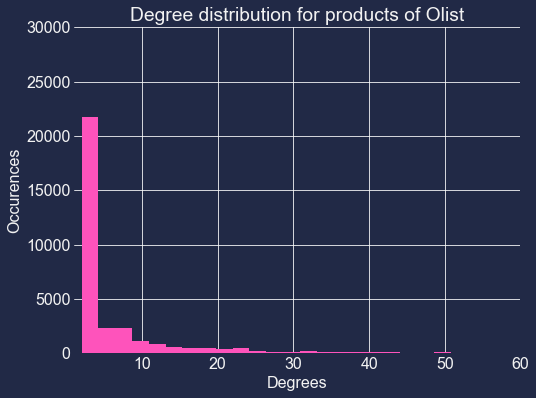

In [48]:
degrees = [G2.degree(n) for n in G2.nodes()]

plt.rcParams["figure.figsize"] = (8,6)

plt.hist(degrees,bins=1000,color='#FE53BB')
plt.title('Degree distribution for products of Olist')
plt.ylabel('Occurences')
plt.xlabel('Degrees')
plt.axis([1, 60, 0, 30000])
plt.show()


In the degree distribution follows a power law distribution which means that about 80% of the orders have less than 10 products.

# 3. Text analysis

In [49]:
df= pd.read_excel(r"olist_reviews_with_translation.xlsx")

In [50]:
df.head()

,Unnamed: 0,review_id,order_id,review_score,review_comment_title,review_comment_title_translated,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_message_translated
0,0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59,NaN
1,1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13,NaN
2,2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24,NaN
3,3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06,I received it well before the stipulated deadl...
4,4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53,Congratulations lannister stores loved shoppin...


## 3.1. Text Cleaning

In [51]:
# Search for NaN values

hasnan_df = 100 * df.isna().sum() / df.shape[0]

# The columns with nans

hasnan_df[hasnan_df > 0]

review_comment_title                 88.285
review_comment_title_translated      88.287
review_comment_message               58.247
review_comment_message_translated    58.275
dtype: float64

In [52]:
#drop all columns with NaN values
df.dropna(inplace=True)

In [53]:
#check for duplicates
pd.concat(g for _, g in df.groupby("review_comment_message_translated") if len(g) > 1)

,Unnamed: 0,review_id,order_id,review_score,review_comment_title,review_comment_title_translated,review_comment_message,review_creation_date,review_answer_timestamp,review_comment_message_translated
38675,38675,e2e44e3eeaa2d29e879b35578df28569,ec864a967206dcb874a7db0ffa6fb17d,5,0,False,0,2018-04-28 00:00:00,2018-05-03 13:09:43,0
52882,52882,22da30dde9db9742eef832df2e82018c,adddc7adab7516dd578d700024245d43,1,00,False,00,2018-07-26 00:00:00,2018-07-30 21:44:40,0
19638,19638,ff9c1c1c60e0d0d8357dcfddd5d30c74,eb7d3683f623a9aa24ed0e4fa4a84c2e,5,10,10,10,2018-07-27 00:00:00,2018-07-27 23:09:39,10
19724,19724,282bc4139e6dc1b0065e4508483df6f8,6447ac90fec2245143232faee2c1728b,5,10,10,10,2018-05-11 00:00:00,2018-05-23 11:11:39,10
23391,23391,72bfa12277357444b874425ec8565963,5cd8853b4ec297e801336f317f9a1912,5,10,10,10,2018-06-26 00:00:00,2018-06-28 17:23:16,10
...,...,...,...,...,...,...,...,...,...,...
90947,90947,e9e81e73f44a0fc9212369c351f9d08b,9a06f6b071c10b11ce8e6e8646dae224,4,otimo,excellent,bom,2018-06-20 00:00:00,2018-06-21 19:04:47,well
95708,95708,352309d398caa4ec54b8b2b1344e39f7,e73e3170000c0a93c0470e40aa0ccf91,4,bOM,well,bOM,2018-06-21 00:00:00,2018-06-21 18:52:18,well
98720,98720,4df691d52d86e49573b02595c6cca3ac,0c2c69625643d98afb22fc2e8dea27ba,4,bom,well,bom,2018-05-18 00:00:00,2018-05-20 23:47:29,well
15106,15106,45b2ed2edcd0290b079318d568578f04,2d30bcdaaf18c2598140aa6f7f230216,4,xx,xx,xx,2018-06-14 00:00:00,2018-06-18 11:31:28,xx


In [54]:
# dropping ALL duplicte values
df.drop_duplicates(subset ="review_comment_message_translated",
                     keep = False, inplace = True)

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8592 entries, 9 to 99975
Data columns (total 10 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   Unnamed: 0                         8592 non-null   int64 
 1   review_id                          8592 non-null   object
 2   order_id                           8592 non-null   object
 3   review_score                       8592 non-null   int64 
 4   review_comment_title               8592 non-null   object
 5   review_comment_title_translated    8592 non-null   object
 6   review_comment_message             8592 non-null   object
 7   review_creation_date               8592 non-null   object
 8   review_answer_timestamp            8592 non-null   object
 9   review_comment_message_translated  8592 non-null   object
dtypes: int64(2), object(8)
memory usage: 738.4+ KB


In [56]:
#keep only the text columns
text = df[['review_comment_title_translated','review_comment_message_translated']]
text

,review_comment_title_translated,review_comment_message_translated
9,I recommend,efficient device. on the website the brand of ...
15,Super recommend,"Reliable seller, ok product and delivery befor..."
19,My product did not arrive,Terrible
34,Very good.,I got exactly what I expected. Other orders fr...
36,Well,"I recommend ,"
...,...,...
99962,Full mark!,"Thank you very much Excellent service, barathe..."
99967,👍,Approved!
99971,very good product,"We were very satisfied with the product, it me..."
99972,The order was not delivered,"Good morning Of the 6 units purchased, I only ..."


In [57]:
text.head(10)

,review_comment_title_translated,review_comment_message_translated
9,I recommend,efficient device. on the website the brand of ...
15,Super recommend,"Reliable seller, ok product and delivery befor..."
19,My product did not arrive,Terrible
34,Very good.,I got exactly what I expected. Other orders fr...
36,Well,"I recommend ,"
38,Amazing!,"I'm completely in love, super responsible and ..."
43,Perfect delivery,Very good. very fragrant.
67,Great Product!,I recommend the seller ...
79,I ALWAYS RECOMMEND !!,The canine patrol backpack kit is beautiful !!...
108,EXCELLENT,OK I RECOMMEND


### 3.1 Normalization of the text and wordcloud vizualization

Before creating the word clouds for the reviews comments and the titles of the reviews, we preprocessed the text. 
Firstly, we removed punctuation from the text of the reviews, we turned every word to lowercase, and removed the stopwords. The final step of this process was the lemmatizing of every word. A lemmatizer converts a word to its original meaningful form.

In [62]:
lemmatizer = WordNetLemmatizer()
STOPWORDS = nltk.corpus.stopwords.words('english')


def text_processing(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(r"\\", "", text)    
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r'\b\w\b', ' ', text)
    text = re.sub('@[^\s]+','',text)
    text = emoji_pattern.sub(r'', text)
    # remove punctuation 
    text = "".join([c for c in text if c not in string.punctuation])
    # lowercase
    text = "".join([c.lower() for c in text])
    # remove stopwords
    text = " ".join([w for w in text.split()  if w not in STOPWORDS])
    # stemming / lematizing (optional)
    text = " ".join([lemmatizer.lemmatize(w) for w in text.split()])
    return text

In [80]:
text_processing_vec = np.vectorize(text_processing)
text['clean_review_comment'] = text['review_comment_message_translated'].astype(str).apply(text_processing_vec)
text['clean_review_title'] = text['review_comment_title_translated'].astype(str).apply(text_processing_vec)

<ipython-input-80-c1b0147c4330>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['clean_review_comment'] = text['review_comment_message_translated'].astype(str).apply(text_processing_vec)
<ipython-input-80-c1b0147c4330>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text['clean_review_title'] = text['review_comment_title_translated'].astype(str).apply(text_processing_vec)


In [81]:
extra_stopwords=['product']
for i in extra_stopwords:
    STOPWORDS.append(i)

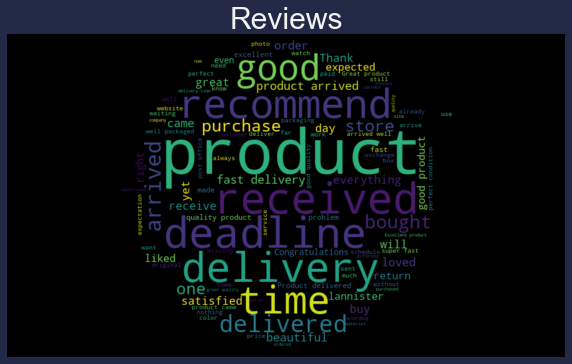

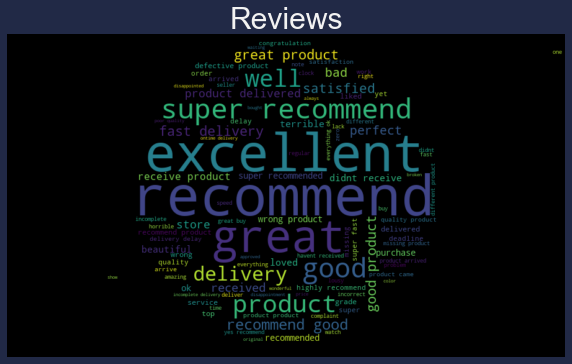

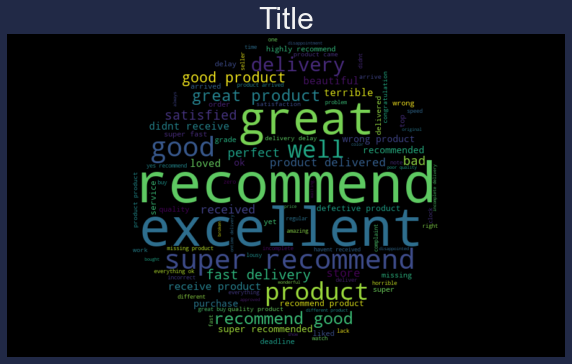

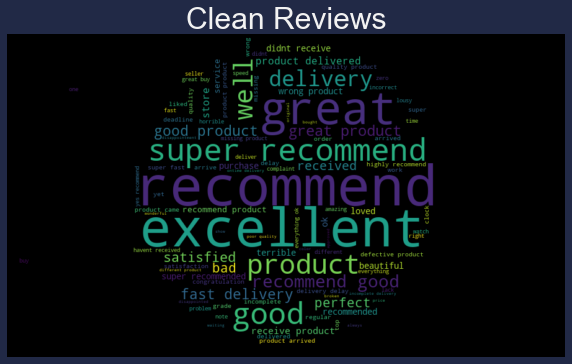

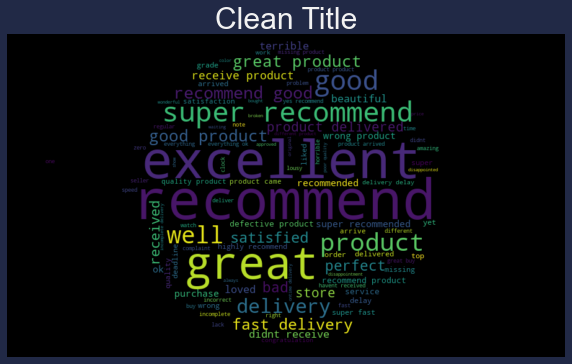

In [73]:
mask_o=np.array(Image.open(r"circle.jpg"))

def show_wordcloud(df, title):
    if title=="Clean Reviews":
      text = ' '.join(df['clean_review_comment'].astype(str).tolist())
    elif title=='Clean Title':
      text = ' '.join(df['clean_review_title'].astype(str).tolist())
    elif title=="Reviews":
      text = ' '.join(df['review_comment_message_translated'].astype(str).tolist())
    elif title=='Title':
      text = ' '.join(df['review_comment_title_translated'].astype(str).tolist())
    
    stopwords = set(wordcloud.STOPWORDS)
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,mask=mask_o,max_font_size=100, max_words=100, background_color="black").generate(text)
    
    plt.figure(figsize=(10,10), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

show_wordcloud(df, "Reviews")


def show_wordcloud(df, title):
    text = ' '.join(df['clean_review_title'].astype(str).tolist())
    stopwords = set(wordcloud.STOPWORDS)
    
    fig_wordcloud = wordcloud.WordCloud(stopwords=stopwords,mask=mask_o,max_font_size=100, max_words=100, background_color="black").generate(text)
    
    plt.figure(figsize=(10,10), frameon=True)
    plt.imshow(fig_wordcloud, interpolation="bilinear")  
    plt.axis('off')
    plt.title(title, fontsize=30)
    plt.show()

show_wordcloud(text, "Reviews")
show_wordcloud(text, "Title")
show_wordcloud(text, "Clean Reviews")
show_wordcloud(text, "Clean Title")


On the first sight it seems that both titles and comments refer to positive reviews.
Below we will do a bit more in depth analysis on the words appear the most. We will illustrate the top uni,bi and tri-grams.

## 3.2. Uni-gram illustration

In [75]:
def get_top_n_words(corpus, n=None):

    ''' Function that return the top uni-grams'''

    corpus = [str (item) for item in corpus]
    corpus = [item for item in corpus if not isinstance(item, int)]
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_bigram(corpus, n=None):

    ''' Function that returns the top bi-grams'''

    corpus = [str (item) for item in corpus]
    corpus = [item for item in corpus if not isinstance(item, int)]
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

def get_top_n_trigram(corpus, n=None):

    ''' Function that returns the top tri-grams'''
    
    corpus = [str (item) for item in corpus]
    corpus = [item for item in corpus if not isinstance(item, int)]
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

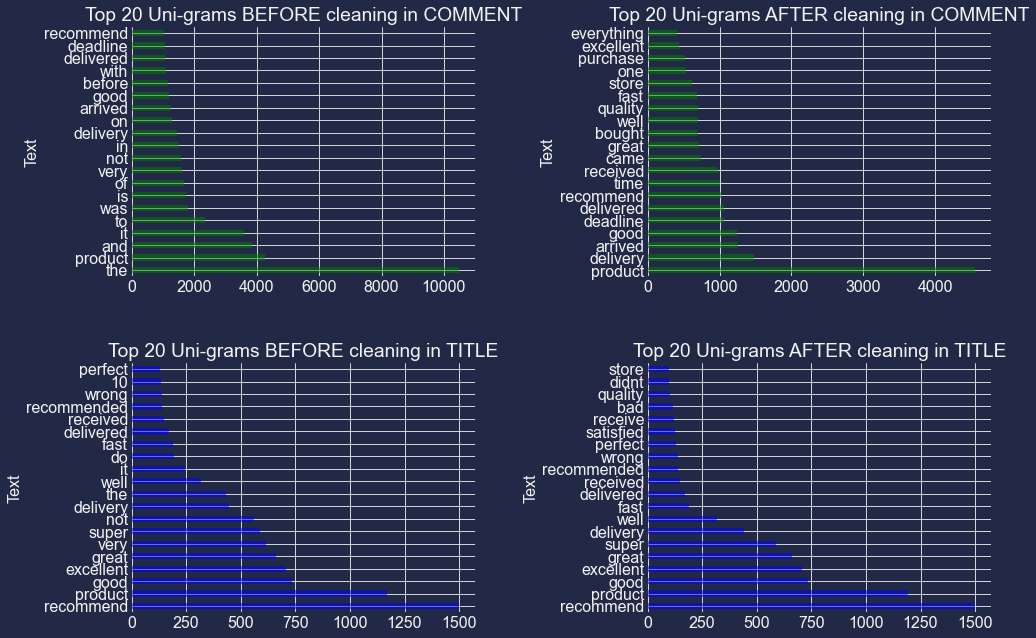

In [76]:
#Plot the top 20 uni-grams for both clean and not-clean text
common_words_message = get_top_n_words(text['review_comment_message_translated'], 20)
common_words_title = get_top_n_words(text['review_comment_title_translated'], 20)
common_words_message_clean = get_top_n_words(text['clean_review_comment'], 20)
common_words_title_clean = get_top_n_words(text['clean_review_title'], 20)

df1 = pd.DataFrame(common_words_message, columns = ['Text' , 'count'])
df2 = pd.DataFrame(common_words_title, columns = ['Text' , 'count'])
df1_clean = pd.DataFrame(common_words_message_clean, columns = ['Text' , 'count'])
df2_clean = pd.DataFrame(common_words_title_clean, columns = ['Text' , 'count'])


fig, axes = plt.subplots(nrows=2,ncols = 2 , sharey=False,figsize=(15,10))
#plt.figure(figsize=(15,10))
df1.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Uni-grams BEFORE cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,0])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Uni-grams BEFORE cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,0])
df1_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Uni-grams AFTER cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,1])
df2_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Uni-grams AFTER cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,1])


fig.tight_layout(pad=3)
plt.show()

Above we can see what are the top 20 words that appear the most in review title(purple) and review comments (green). 
Clearly in comment section where we have longer sentences the so called stopwards appear the most. After cleaning the text it's more clear what are the most frequent words. 

On the other hand in review titles stopwords don't appear often as the length of sentences is shorter that in the reviews.
We can see in titles (clean) there are words such as wrong and bad which indicate a bad review. However, in comment section we don't observe such a words.

In order to make it more clear we will try to illustrate the most frequent bi-grams.

## 3.3 Bi-gram illustration

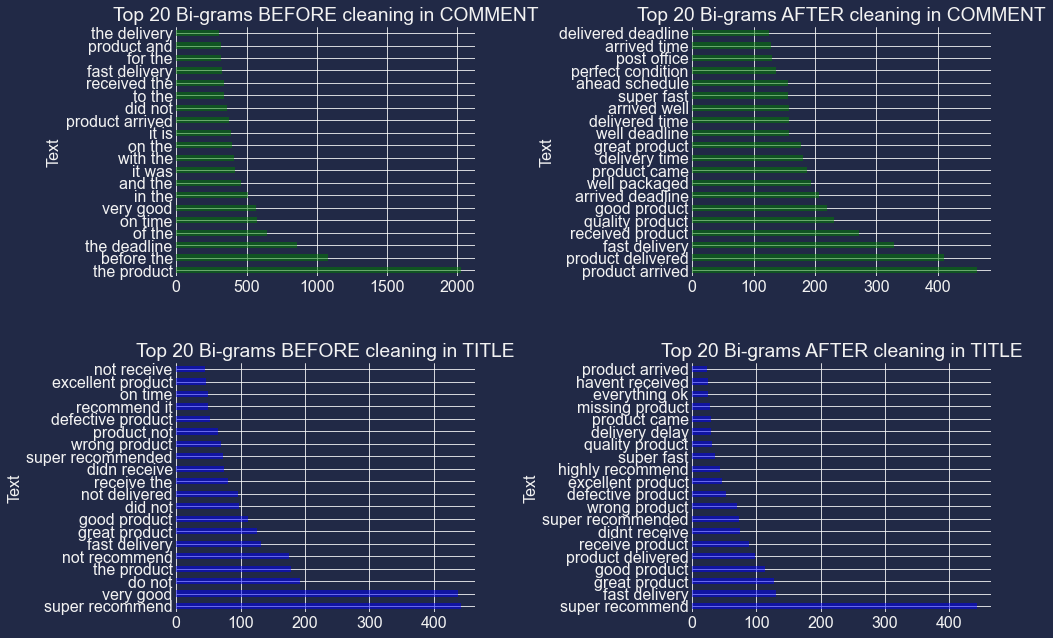

In [77]:
common_words_message = get_top_n_bigram(text['review_comment_message_translated'], 20)
common_words_title = get_top_n_bigram(text['review_comment_title_translated'], 20)
common_words_message_clean = get_top_n_bigram(text['clean_review_comment'], 20)
common_words_title_clean = get_top_n_bigram(text['clean_review_title'], 20)



df1 = pd.DataFrame(common_words_message, columns = ['Text' , 'count'])
df2 = pd.DataFrame(common_words_title, columns = ['Text' , 'count'])
df1_clean = pd.DataFrame(common_words_message_clean, columns = ['Text' , 'count'])
df2_clean = pd.DataFrame(common_words_title_clean, columns = ['Text' , 'count'])


fig, axes = plt.subplots(nrows=2,ncols = 2 , sharey=False,figsize=(15,10))
#plt.figure(figsize=(15,10))
df1.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Bi-grams BEFORE cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,0])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Bi-grams BEFORE cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,0])
df1_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Bi-grams AFTER cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,1])
df2_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Bi-grams AFTER cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,1])


fig.tight_layout(pad=3)
plt.show()

By analysing the most frequent bi-grams we still observe that in the commnet section (top-right) tend to refer to a positive feedback.
However, in title (bottom-right) there are mixed frequent bi-grams.

## 3.4. Tri-gram illustration

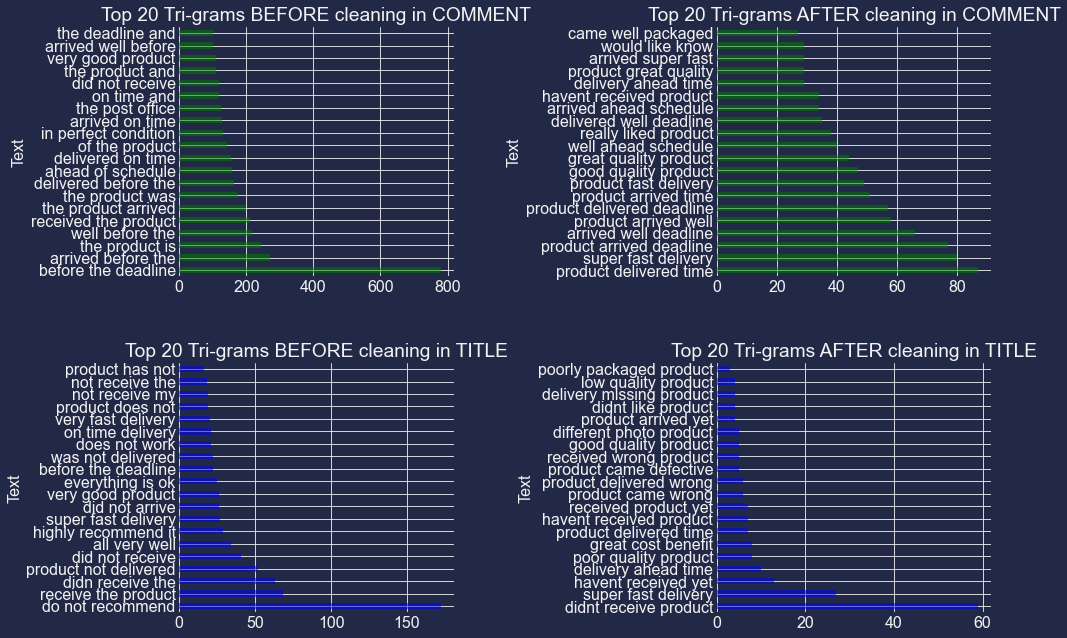

In [78]:
common_words_message = get_top_n_trigram(text['review_comment_message_translated'], 20)
common_words_title = get_top_n_trigram(text['review_comment_title_translated'], 20)
common_words_message_clean = get_top_n_trigram(text['clean_review_comment'], 20)
common_words_title_clean = get_top_n_trigram(text['clean_review_title'], 20)


df1 = pd.DataFrame(common_words_message, columns = ['Text' , 'count'])
df2 = pd.DataFrame(common_words_title, columns = ['Text' , 'count'])
df1_clean = pd.DataFrame(common_words_message_clean, columns = ['Text' , 'count'])
df2_clean = pd.DataFrame(common_words_title_clean, columns = ['Text' , 'count'])


fig, axes = plt.subplots(nrows=2,ncols = 2 , sharey=False,figsize=(15,10))
#plt.figure(figsize=(15,10))
df1.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Tri-grams BEFORE cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,0])
df2.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Tri-grams BEFORE cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,0])
df1_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Tri-grams AFTER cleaning in COMMENT',
                                                                     alpha=0.5,
                                                                     facecolor='Green', ax=axes[0,1])
df2_clean.groupby('Text').sum()['count'].sort_values(ascending=False).plot(kind='barh', 
                                                                     title= 'Top 20 Tri-grams AFTER cleaning in TITLE',
                                                                     alpha=0.5,
                                                                  facecolor='Blue', ax=axes[1,1])


fig.tight_layout(pad=3)
plt.show()


Using tri-grams in order to add better understand what appears the most both in title and comment section. We observe again a discrepancy between titles and comments. Comments overall seem to refer to a positive feedback while in title the opposite.

## 3.5. Topic modeling with LDA

LDA (Latent Dirichlet Allocation) is an unsupervised machine learning technique that is used to classify text to a particular topic. We are planning to use it to get insights on user satisfaction for Olist and possible complaints.

First step for LDA topic modeling is to turn the text into a format that can be used in machine learning. This process is called "vectorization".

In [82]:
# Vectorize reviews comments

vectorizer_comments = CountVectorizer(ngram_range=(2, 2))
bow_counts_comments = vectorizer_comments.fit_transform(text['clean_review_comment'].values)


vectorizer_title = CountVectorizer()
bow_counts_title = vectorizer_title.fit_transform(text['clean_review_title'].values)

# print(bow_counts_comments[0])
# print(vectorizer_comments.get_feature_names())
print('Vectorizer Comments',len(vectorizer_comments.vocabulary_))
print('Vectorizer Title',len(vectorizer_title.vocabulary_))

Vectorizer Comments 30217
Vectorizer Title 1413


Second step for the topic modeling is building the model. It will classify the text of the comments in 3 different topics.

In [83]:
from sklearn.decomposition import LatentDirichletAllocation

# empty model
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5,
                                learning_method='online',
                                learning_offset=50.,
                                random_state=0)
comments_lda = lda.fit_transform(bow_counts_comments)
titles_lda = lda.fit_transform(bow_counts_title)

In [84]:
# Function that prints n top words
# Ref: Course's Notebook text Analysis - Part 1 - Spam Classification-solutions
def print_top_words(model, feature_names, n_top_words):
    norm = model.components_.sum(axis=1)[:, np.newaxis]
    for topic_idx, topic in enumerate(model.components_):
        print(80 * "-")
        print("Topic {}".format(topic_idx))
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            print("{:.3f}".format(topic[i] / norm[topic_idx][0]) 
                  + '\t' + feature_names[i])

In [85]:
print("\nTopics in LDA model:")
counts_feature_names = vectorizer_comments.get_feature_names()
n_top_words = 10
print_top_words(lda, counts_feature_names, n_top_words)


Topics in LDA model:
--------------------------------------------------------------------------------
Topic 0
0.298	agreed five
0.128	arrive day
0.046	according nr
0.039	apparently everything
0.032	according right
0.031	already repaid
0.018	adhesive loved
0.013	arrive time
0.012	arrive courier
0.012	another gps
--------------------------------------------------------------------------------
Topic 1
0.042	appears two
0.040	always effectiveness
0.037	also last
0.035	accordance need
0.032	almost information
0.021	approval reach
0.014	answer received
0.013	another voltage
0.013	apparent defect
0.012	amperage offered
--------------------------------------------------------------------------------
Topic 2
0.323	affected parcel
0.055	answer result
0.029	announced targaryen
0.023	already informed
0.021	actually delivered
0.015	already discounted
0.014	adjustment run
0.011	also inform
0.009	arrive took
0.009	arrive lost
--------------------------------------------------------------------------

From the topic modelling in comment section it's not very clear what kind of different topics are created. It seems that all of them are somehow related.

In [86]:
print("\nTopics in Title LDA model:")
counts_feature_names = vectorizer_title.get_feature_names()
n_top_words = 10
print_top_words(lda, counts_feature_names, n_top_words)


Topics in Title LDA model:
--------------------------------------------------------------------------------
Topic 0
0.298	good
0.128	well
0.046	bad
0.039	store
0.032	beautiful
0.031	loved
0.018	deadline
0.013	yes
0.012	watch
0.012	regular
--------------------------------------------------------------------------------
Topic 1
0.042	terrible
0.040	order
0.037	missing
0.035	arrived
0.032	incomplete
0.021	top
0.014	satisfaction
0.013	right
0.013	still
0.012	problem
--------------------------------------------------------------------------------
Topic 2
0.323	excellent
0.055	satisfied
0.029	purchase
0.023	liked
0.021	buy
0.015	lack
0.014	deliver
0.011	misleading
0.009	zero
0.009	wonderful
--------------------------------------------------------------------------------
Topic 3
0.392	recommend
0.156	super
0.047	delivered
0.037	received
0.032	receive
0.027	quality
0.025	didnt
0.018	delay
0.014	yet
0.014	highly
--------------------------------------------------------------------------------
T

From topic modelling on the titles we can make better conclusion on the topics. For example topic 1 depicts reviews about the product and whether deliver in good or bad condition. We can see words such as delivered wrong, incomplete, terrible.
In topice 4 however we can see that refers to delivery in general. Here words such as fast and perfect appear indicating that the delivery performance is good.

## 3.6 Sentiment analysis

After generating the wordclouds for each review titles and review comments our group performed a sentiment analysis. The sentiment analysis was based on the the data from *Temporal Patterns of Happiness and Information in a Global Social Network: Hedonometrics and Twitter  (Dataset S1)*.

In [90]:
happinessDf = pd.read_csv(r"happylist.csv",'\t')
happinessDf.head()

,word,happiness_rank,happiness_average,happiness_standard_deviation,twitter_rank,google_rank,nyt_rank,lyrics_rank
0,laughter,1,8.50,0.9313,3600,--,--,1728
1,happiness,2,8.44,0.9723,1853,2458,--,1230
2,love,3,8.42,1.1082,25,317,328,23
3,happy,4,8.30,0.9949,65,1372,1313,375
4,laughed,5,8.26,1.1572,3334,3542,--,2332


In [91]:
def Sentiment(liste):
    value=[]
    sums=[]
    list1=dict(nltk.FreqDist(liste)) #Find the frequency of the words
    for word in list1.keys():
        if word in list(happinessDf['word']): # Check if word is in the dataset
            c=happinessDf['happiness_average'][list(happinessDf['word']).index(word)]*list1[word] #Find the happiness_average value
            value.append(c) # Save the happiness_average value
            sums.append(list1[word]) # Save the frequncy of the words 
    if len(value)>0: 
        return sum(value)/sum(sums) # Sentiment score
    else:
        return 0

In [93]:
clean_reviews = list(text["clean_review_comment"].values)
sentiment_scores=[]
for indx,i in enumerate(clean_reviews):
    sentiment_scores.append(Sentiment(i))


In [94]:
Reviews_scores = pd.DataFrame(
    {'Review': clean_reviews,
     'Sentiment Score': sentiment_scores
    })

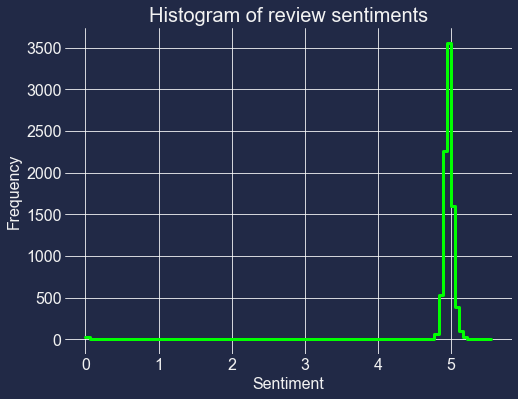

In [95]:
hist, bins = np.histogram(sentiment_scores, bins = 100)

plt.figure(figsize=(8,6))
plt.plot(bins, np.insert(hist, 0, hist[0]), drawstyle='steps')
plt.title("Histogram of review sentiments", size=20)
plt.xlabel("Sentiment",size=16)
plt.ylabel("Frequency",size=16)
plt.show()

We can see from the histogram that most reviews score between 4.5 to 5.5 and there is some reviews with a sentiment of 0. This means that the review does not contain any words from the happiness dataset.

# Conclusion

As shown both in wordclouds and in the topic modelling, most reviews are positive.

The topic analysis revealed that the titles are more approriate to categorize reviews into specific topics. The fact that the titles are short and direct sentences gives better understanding about the review on the contrary to the comment. As a future step we could use LDA to predict in what topic each of the comment reviews falls in.